In [1]:
%matplotlib inline
from __future__ import print_function, unicode_literals
import sys, os, glob
import re
import datetime as dt
import seaborn as sns
import json
from collections import OrderedDict

In [2]:
from pygaarst import raster
sys.path.append("../firedetection/")
import viirstools as vt
import viirsswathtools as vst
import viirsifire as vif

In [3]:
reload(vif)

<module 'viirsifire' from '../firedetection/viirsifire.pyc'>

In [4]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
import fiona.crs
from shapely.geometry import Polygon, Point, LineString
import shapely.wkt
import pandas as pd
import geopandas as gp

In [6]:
ALT1 = True
ALT2 = False 

basedir = '/Volumes/cwdata1/VIIRS/GINA/dds.gina.alaska.edu/NPP/viirs/'
outdir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/rasterout/'
if ALT1:
    basedir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/'
elif ALT2:
    basedir = '/Volumes/SCIENCE/Fire/DATA_BY_AREA/2015/VIIRS/'

if os.path.isdir(basedir):
    print(basedir, "exists")
else:
    print("Please check directory {}: cannot access it.".format(basedir))

Please check directory /Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/: cannot access it.


In [7]:
granulecatalogfn = 'viirsgranulecatalog_in_ROI.json'

In [8]:
sockeye_lon, sockeye_lat = (-150.08544, 61.84486)
fairbanks_lon, fairbanks_lat = (-147.723056, 64.843611)
sample_lon, sample_lat = sockeye_lon, sockeye_lat
sampleloc = Point(sample_lon, sample_lat)

In [9]:
roi = gp.GeoDataFrame.from_file('../data/BorealAKForUAFSmoke.json')

In [10]:
with open(os.path.join(basedir, granulecatalogfn), 'rU') as src:
    granuledir = json.load(src)

IOError: [Errno 2] No such file or directory: u'/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/viirsgranulecatalog_in_ROI.json'

In [ ]:
crs = fiona.crs.from_epsg('4326')
granuleDF = pd.DataFrame.from_dict(granuledir, orient='index')
granuleDF = granuleDF.loc[granuleDF['iband_complete']]
granuleDF['geometry'] = granuleDF['edgepolygon_I'].apply(shapely.wkt.loads)

granuleDF = gp.GeoDataFrame(
    granuleDF, 
    crs=crs,
    geometry=granuleDF.geometry)
granuleDF = granuleDF.loc[granuleDF['geometry'].contains(sampleloc), :]
print(granuleDF.shape)
granuleDF.head()

In [11]:
idx = granuleDF.index

NameError: name 'granuleDF' is not defined

In [12]:
startdate = '20150614'
enddate = '20150620'
granules = [idx for idx in granuleDF.index if idx > startdate and idx < enddate]
granuleDF.loc[granules]


NameError: name 'granuleDF' is not defined

In [13]:
roi

,Description,Name,geometry
0,,Boreal AK and adjacent CA,POLYGON Z ((-166.184299324089 69.0368403963698...


In [16]:
testgranule = granuleDF.loc[u'20150615_2309183']
testpath01 = os.path.join(testgranule['dir'], testgranule['SVI01'])
testpath02 = os.path.join(testgranule['dir'], testgranule['SVI02'])
testpath03 = os.path.join(testgranule['dir'], testgranule['SVI03'])
testscene04 = raster.VIIRSHDF5(os.path.join(testgranule['dir'], testgranule['SVI04']))
testscene05 = raster.VIIRSHDF5(os.path.join(testgranule['dir'], testgranule['SVI05']))

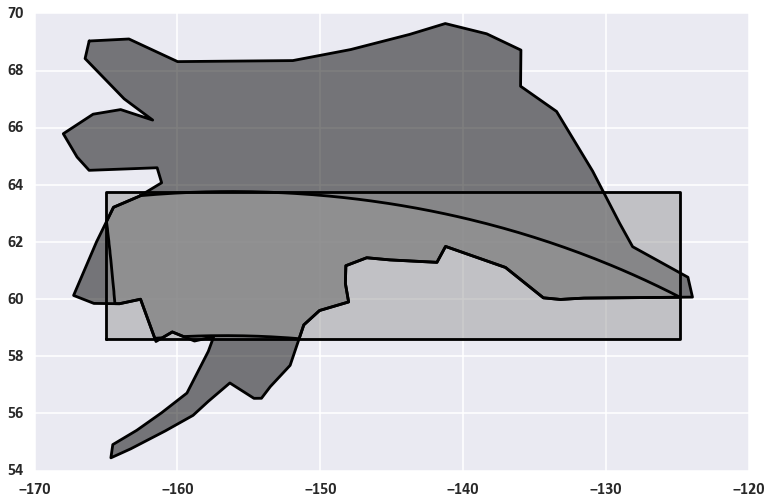

In [73]:
testpoly1 = granuleDF.loc[u'20150615_1135074':'20150615_1135074']
#testpoly1.plot()
testpoly = granuleDF.loc[u'20150615_1135074']['geometry']
roi.plot()
#gp.GeoSeries([granuleDF.loc[u'20150614_2007390']['geometry'].intersection(roi['geometry'][0]).envelope]).plot()
#gp.GeoSeries([granuleDF.loc[u'20150614_2007390']['geometry'].intersection(
#            roi['geometry'][0]).convex_hull.simplify(0.25)]).plot()
gp.GeoSeries([testpoly.intersection(roi.geometry[0])]).plot()
gp.GeoSeries([testpoly.intersection(roi.geometry[0]).envelope]).plot()
ax2 = plt.gca()
ax2.set_ylim(54, 70)
ax2.set_xlim(-170, -120)
ax2.set_aspect(2)

In [17]:
testscene = testscene04
testscene.lats.shape

(1536, 6400)

In [22]:
testpoly = granuleDF.loc[u'20150614_2007390']['geometry']
roipoly = roi.geometry[0]
for corner in testpoly.intersection(roipoly).envelope.boundary.intersection(roipoly.boundary):
    print(corner.x, corner.y)

-148.030962732 59.9304214048
-135.97673798 67.8108829654
-129.77339011 60.0452233757
-129.77339011 63.3580537725


In [50]:
testscene04.getnearestidx(63.3580537725, -129.77339011)

(0, 3774)

In [51]:
testscene04.ascending_node

False

In [18]:
roipoly = roi['geometry'][0]
intersect = testpoly.intersection(roipoly)
intersect.envelope.boundary.intersection(roipoly.boundary)

NameError: name 'testpoly' is not defined

In [26]:
#%%timeit
imin = 1536
jmin = 6400
imax = jmax = 0
testpoly = granuleDF.loc[u'20150614_2007390']['geometry']
corners = testpoly.intersection(roipoly).envelope.intersection(roipoly.boundary).boundary
for corner in corners:
    lon, lat = corner.x, corner.y
    ii, jj = testscene.getnearestidx(lat, lon)
    if ii < imin:
        imin = ii
    if ii > imax:
        imax = ii 
    if jj < jmin:
        jmin = jj 
    if jj > jmax:
        jmax = jj 
print (imin, imax, jmin, jmax)

258 1535 0 1701


In [20]:
%%timeit
imin = 1536
jmin = 6400
imax = jmax = 0
for lon, lat in granuleDF.loc[u'20150614_2007390']['geometry'].intersection(roi['geometry'][0]).envelope.boundary.coords[:-1]:
    ii, jj = testscene.getnearestidx(lat, lon)
    if ii < imin:
        imin = ii
    if ii > imax:
        imax = ii 
    if jj < jmin:
        jmin = jj 
    if jj > jmax:
        jmax = jj 
print (imin, imax, jmin, jmax)

255 1535 0 2130
255 1535 0 2130
255 1535 0 2130
255 1535 0 2130
1 loop, best of 3: 6.26 s per loop


In [21]:
%%timeit
imin = 1536
jmin = 6400
imax = jmax = 0
for lon, lat, _ in granuleDF.loc[u'20150614_2007390']['geometry'].intersection(roi['geometry'][0]).convex_hull.simplify(0.25).boundary.coords[:-1]:
    ii, jj = testscene.getnearestidx(lat, lon)
    if ii < imin:
        imin = ii
    if ii > imax:
        imax = ii 
    if jj < jmin:
        jmin = jj 
    if jj > jmax:
        jmax = jj 
print (imin, imax, jmin, jmax)

258 1535 0 2069
258 1535 0 2069
258 1535 0 2069
258 1535 0 2069
1 loop, best of 3: 11.3 s per loop


In [18]:
gisbasedir = "/Volumes/SCIENCE_mobile_Mac/GENERAL_GIS/"
productdir = "/Users/chris/Dropbox/Research/PhD/2015VIRSPaper/Sockeye_img/"

In [19]:
railroads = os.path.join(gisbasedir, "matsugov.us/rr/railroad_latlon")
primaryroads = os.path.join(gisbasedir, "catalog.data.gov/tl_2013_02_prisecroads/tl_2013_02_prisecroads")
sideroads = os.path.join(gisbasedir, "matsugov.us/rds/rds_latlon")

In [20]:
earth='cornsilk'
water='lightskyblue'

In [49]:
sns.set(rc={'image.cmap': 'gist_heat'})
#sns.set(rc={'image.cmap': 'magma'})
sns.set_context("poster", font_scale=1.5)

myfontsize = 20
font = {'family' : 'Calibri',
        'weight': 'bold',
        'size'   : myfontsize}
matplotlib.rc('font', **font)
matplotlib.axes.rcParams['axes.labelsize']=myfontsize-4
matplotlib.axes.rcParams['axes.titlesize']=myfontsize
cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))


In [22]:
cbarfraction = 0.05
cbarpad = 0.05

#imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, 500, 400)
imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, 50, 50)
print(
    imin, imax, jmin, jmax, 
    testscene04.lats[testscene04.getnearestidx(sample_lat, sample_lon)], 
    testscene04.lons[testscene04.getnearestidx(sample_lat, sample_lon)]
)
print(sample_lat, sample_lon)
datestamp = vt.getdatestamp_AKDT(testscene04)
pixelq4 = testscene04.pixelquality[imin:imax, jmin:jmax]
pixelq5 = testscene05.pixelquality[imin:imax, jmin:jmax]
# find row indices where no data present
excluderows = np.where((pixelq4[:, 0] == 2) | (pixelq4[:, -1] == 2) )


824 925 1818 1919 61.8441 -150.087
61.84486 -150.08544


In [23]:
print(datestamp)

2015-06-15 15:09:18 AKDT


In [24]:
testscene04.meta

{u'Data_Product': {u'AggregateBeginningDate': u'20150615',
  u'AggregateBeginningGranuleID': u'NPP001150817578',
  u'AggregateBeginningOrbitNumber': u'18821',
  u'AggregateBeginningTime': u'230918.352825Z',
  u'AggregateEndingDate': u'20150615',
  u'AggregateEndingGranuleID': u'NPP001150817578',
  u'AggregateEndingOrbitNumber': u'18821',
  u'AggregateEndingTime': u'231042.528429Z',
  u'Instrument_Short_Name': u'VIIRS',
  u'N_Collection_Short_Name': u'VIIRS-I4-SDR',
  u'N_Dataset_Type_Tag': u'SDR',
  u'N_Processing_Domain': u'OPS'},
 u'Distributor': u'cspp',
 u'Mission_Name': u'NPP',
 u'N_Dataset_Source': u'all-',
 u'N_GEO_Ref': u'GITCO_npp_d20150615_t2309183_e2310425_b18821_c20150615233131914882_cspp_dev.h5',
 u'N_HDF_Creation_Date': u'20150615',
 u'N_HDF_Creation_Time': u'233134.583144Z',
 u'Number_of_Data_Products': u'1',
 u'Platform_Short_Name': u'NPP'}

In [25]:
nightscene = True
zenithangles = testscene04.geodata['SolarZenithAngle'][imin:imax, jmin:jmax]
if np.all(zenithangles <= 90.):
    nightscene = False
elif (np.any(zenithangles > 90.) & np.any(zenithangles <= 90.)):
    print("WARNING: mixed scene with zenith angles above and below 90°.")
print(nightscene)

False


In [26]:
print(testscene04.ascending_node)

True


In [27]:
imin, imax, jmin, jmax

(824, 925, 1818, 1919)

In [28]:
rasterlist = []
excluderows

(array([ 6,  7,  8,  9, 38, 39, 40, 41, 70, 71, 72, 73]),)

## Calculate cells with at duplicate locations

In [29]:
skips = vst.get_skips(testscene04, imin, imax, jmin, jmax)
skiprows = vst.get_badrows(skips)
skiprows

array([ 4,  5,  6,  7,  8,  9, 10, 36, 37, 38, 39, 40, 41, 42, 68, 69, 70,
       71, 72, 73, 74])

## Plots

[]

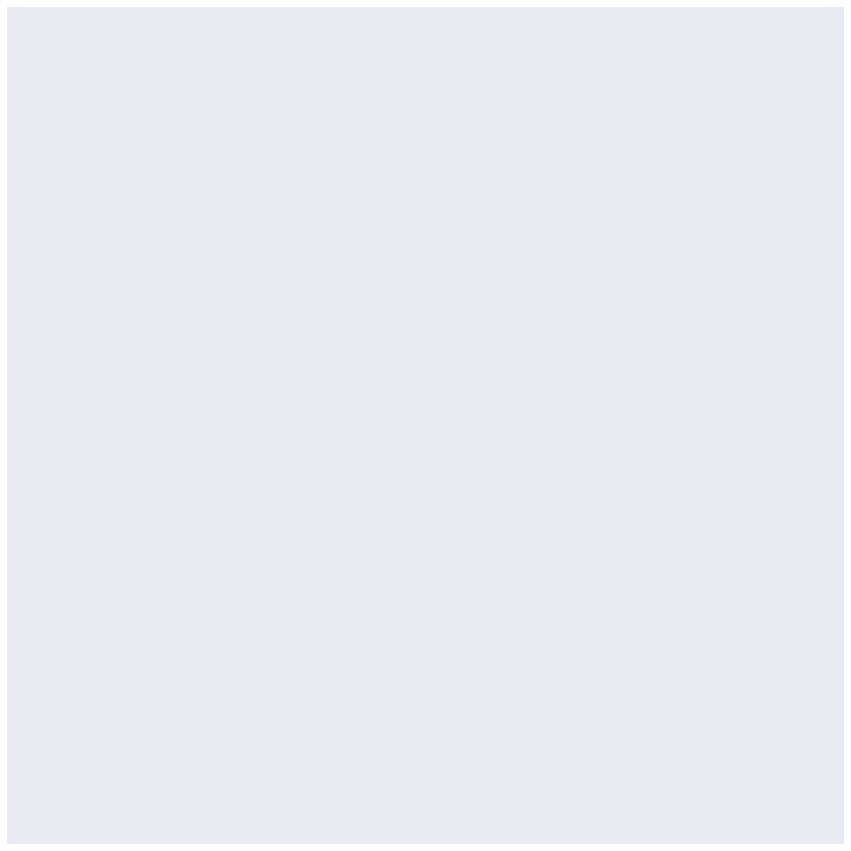

In [14]:
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])


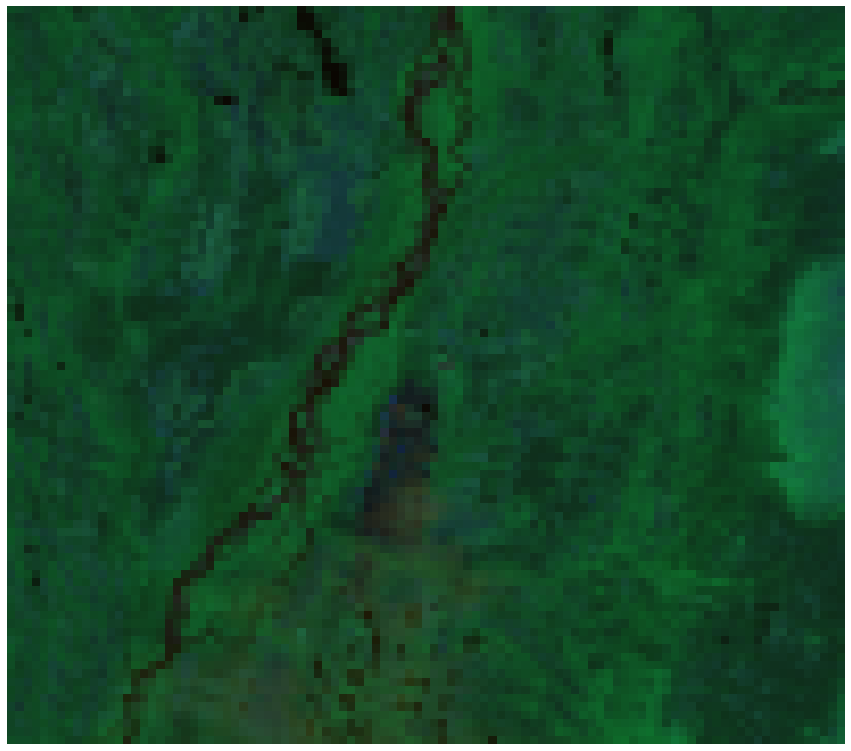

In [30]:
# zeroth plot: visible RGB, just for fun

plotrasters = []
for datapath in [testpath01, testpath02, testpath03]:
    scene = raster.VIIRSHDF5(datapath)
    bandname = scene.bandname
    testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
    mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
    plotraster = np.fliplr(testdat*mult + add)
    plotraster = np.delete(plotraster, excluderows, 0)
    plotrasters.append(plotraster)

rgbraster = np.dstack(plotrasters)

if testscene04.ascending_node:
    rgbraster = np.flipud(rgbraster)
else:
    rgbraster = np.fliplr(rgbraster)

a#dataplot = ax1.imshow(np.flipud(plotraster) , interpolation='nearest', cmap='bone')
dataplot = ax1.imshow(rgbraster, interpolation='nearest')
#ax1.set_title('Western Alaska: Overview plot from band {}, {}'.format(
#        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
#plt.savefig("/Users/cwaigl/Desktop/testfires.png", dpi=300)
plt.show()

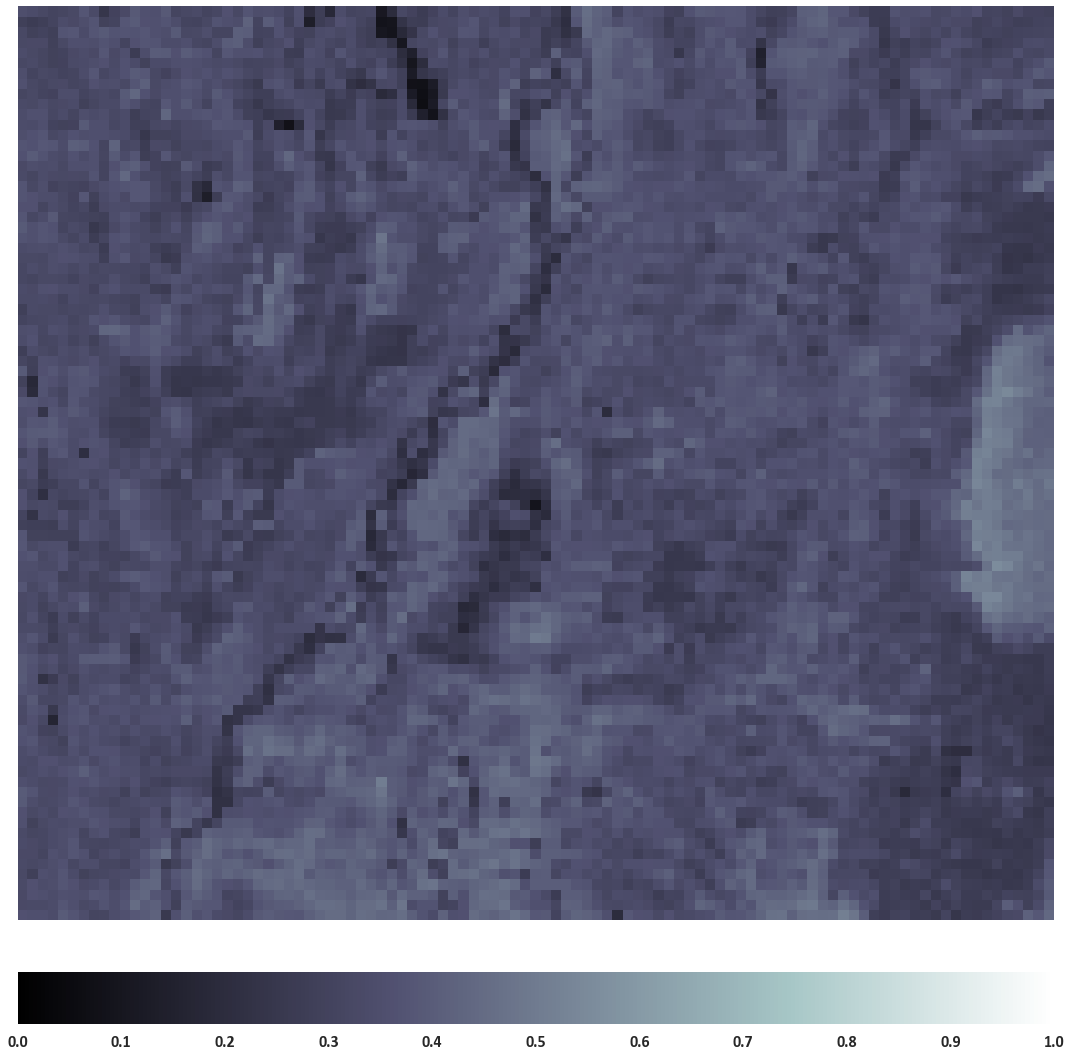

In [31]:
# zeroth plot prime: print sum of first two bands reflectance:

scene = raster.VIIRSHDF5(testpath01)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster1 = np.fliplr(testdat*mult + add)
plotraster1 = np.delete(plotraster1, excluderows, 0)

scene = raster.VIIRSHDF5(testpath02)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster2 = np.fliplr(testdat*mult + add)
plotraster2 = np.delete(plotraster2, excluderows, 0)

scene = testscene04
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]
plotraster4 = np.fliplr(testdat*mult + add)
plotraster4 = np.delete(plotraster4, excluderows, 0)

scene = testscene05
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]
plotraster5 = np.fliplr(testdat*mult + add)
plotraster5 = np.delete(plotraster5, excluderows, 0)

if nightscene:
    cloudcondition = np.logical_and(
        plotraster4 < 295, plotraster5 < 265
    )
else:
    cloudcondition = np.logical_or(
        plotraster5 < 265, 
        np.logical_and(plotraster1 + plotraster2 > 0.9, plotraster5 < 295)
    )
    cloudcondition = np.logical_or(
        cloudcondition,
        np.logical_and(plotraster1 + plotraster2 > 0.7, plotraster5 < 285),
    )
cloudmask = np.ma.masked_where(
        ~cloudcondition, np.ones(plotraster5.shape))

cmap4 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'turquoise']))

if not testscene04.ascending_node:
    for rast in [plotraster1, plotraster2, plotraster5]:
        rast = np.flipud(np.fliplr(rast))

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.pcolormesh(plotraster1+plotraster2, cmap='bone', vmin=0, vmax=1)
cloudplot = ax1.pcolormesh(cloudmask, cmap=cmap4, vmin=0, vmax=1)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)

#ax1.set_title('Western Alaska: Overview plot from band {}, {}'.format(
#        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
#plt.savefig("testfires")
plt.show()

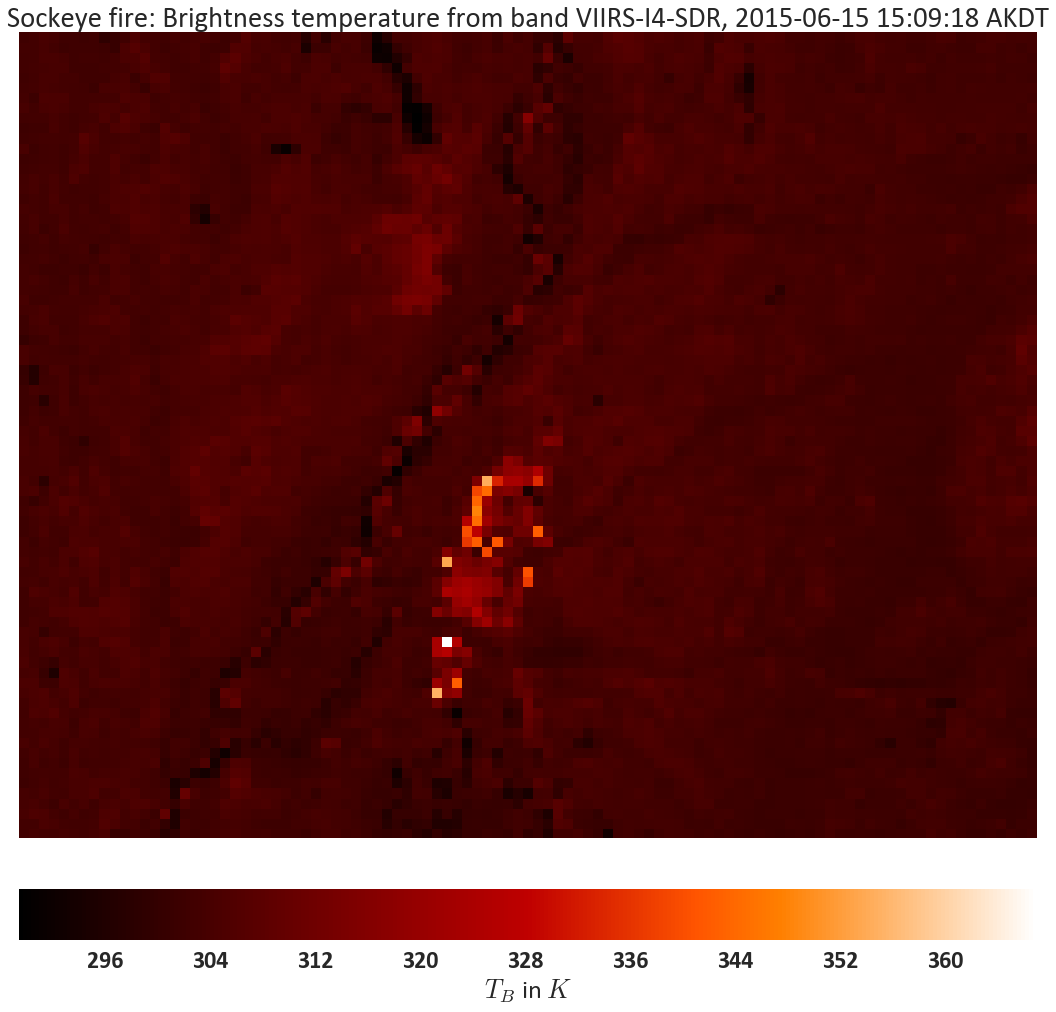

In [52]:
sns.set_context("poster", font_scale=1.5)

# first plot
scene = testscene04
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]

testdat = testdat*mult + add
rasterlist.append(testdat)
plotraster = np.fliplr(np.delete(testdat, skiprows, 0))

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
#dataplot = ax1.imshow(np.flipud(plotraster) , interpolation='nearest', vmin=280, vmax=370)
#dataplot = ax1.pcolormesh(plotraster, vmin=260, vmax=340)
dataplot = ax1.pcolormesh(plotraster)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$T_B$ in $K$")
ax1.set_title('Sockeye fire: Brightness temperature from band {}, {}'.format(
        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
plt.show()

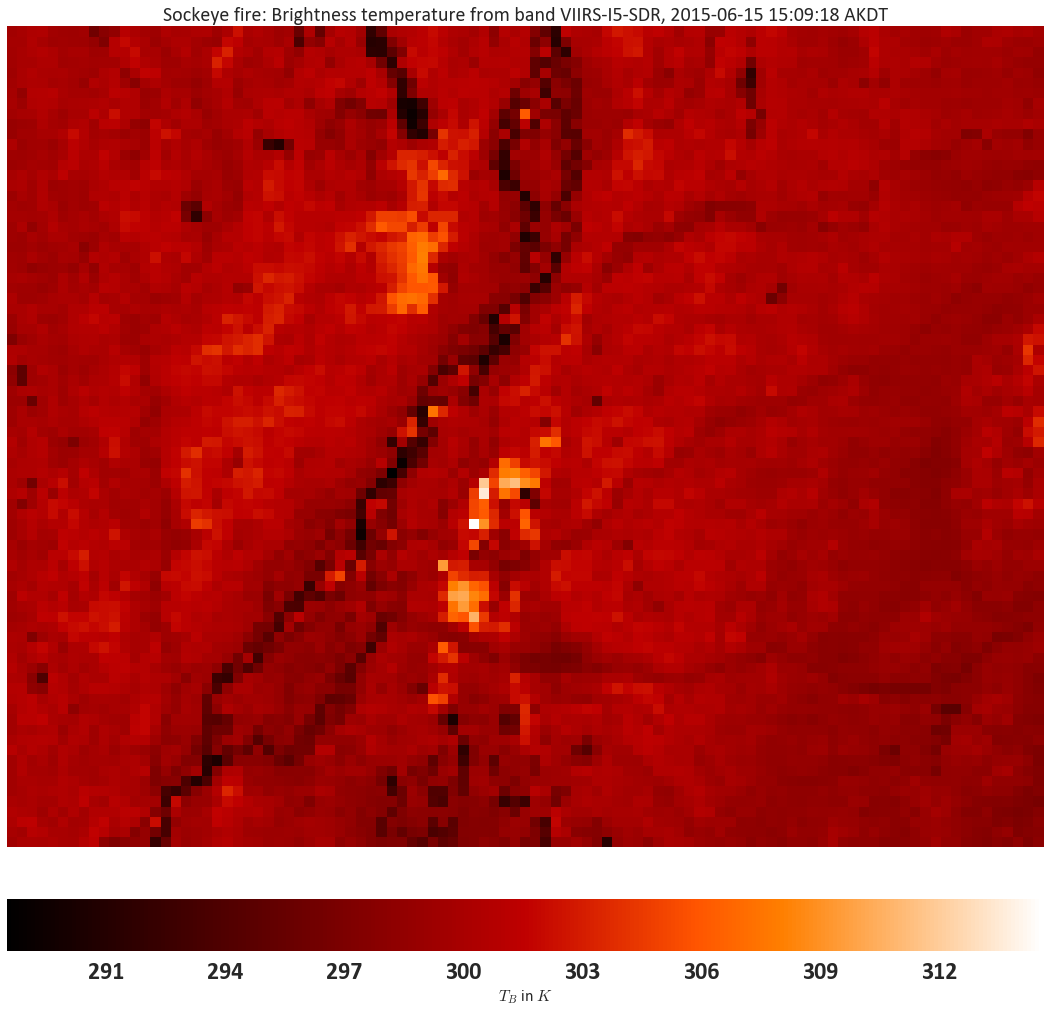

In [51]:
# second plot
scene = testscene05
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]

testdat = testdat*mult + add
rasterlist.append(testdat)
plotraster = np.fliplr(np.delete(testdat, skiprows, 0))

plotraster_river = np.ma.masked_where(plotraster <= 295, np.ones(plotraster.shape))

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
#dataplot = ax1.imshow(np.flipud(plotraster) , interpolation='nearest', vmin=280, vmax=370)
dataplot = ax1.pcolormesh(plotraster)
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$T_B$ in $K$")
ax1.set_title('Sockeye fire: Brightness temperature from band {}, {}'.format(
        scene.meta['Data_Product']['N_Collection_Short_Name'], datestamp))
plt.show()

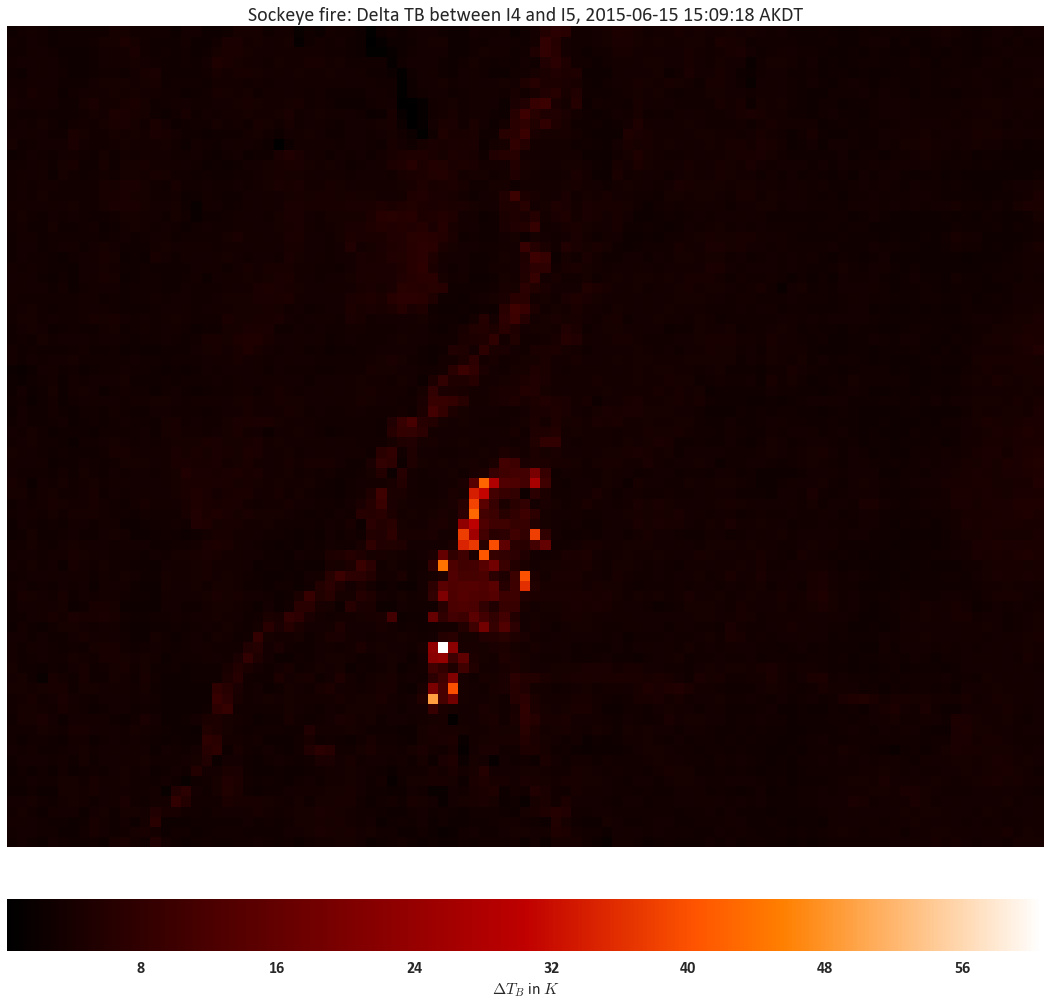

In [34]:
# third plot
plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  plotraster4 - plotraster5
plotraster45 = np.delete(plotraster45, skiprows, 0)


fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.pcolormesh(np.fliplr(plotraster45))
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("$\Delta T_B$ in $K$")
ax1.set_title('Sockeye fire: Delta TB between I4 and I5, {}'.format(datestamp))
plt.show()

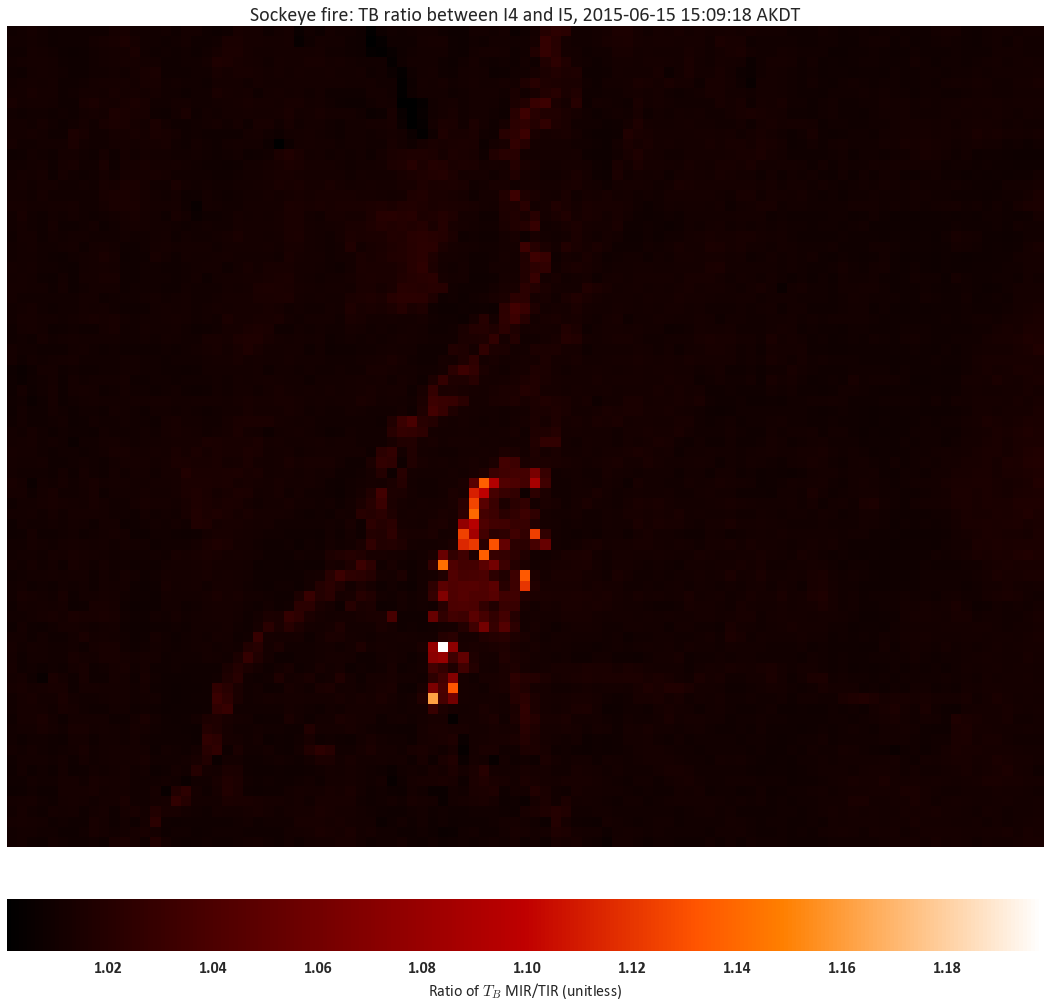

In [35]:
# fourth plot: ratio
plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  plotraster4 / plotraster5
plotraster45 = np.delete(plotraster45, skiprows, 0)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
dataplot = ax1.pcolormesh(np.fliplr(plotraster45))
ax1.set_aspect('equal')
ax1.set_xlim(0, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()
cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label("Ratio of $T_B$ MIR/TIR (unitless)")
ax1.set_title('Sockeye fire: TB ratio between I4 and I5, {}'.format(datestamp))
plt.show()


In [36]:
reload(vif)

<module 'viirsifire' from '../firedetection/viirsifire.pyc'>

It's day


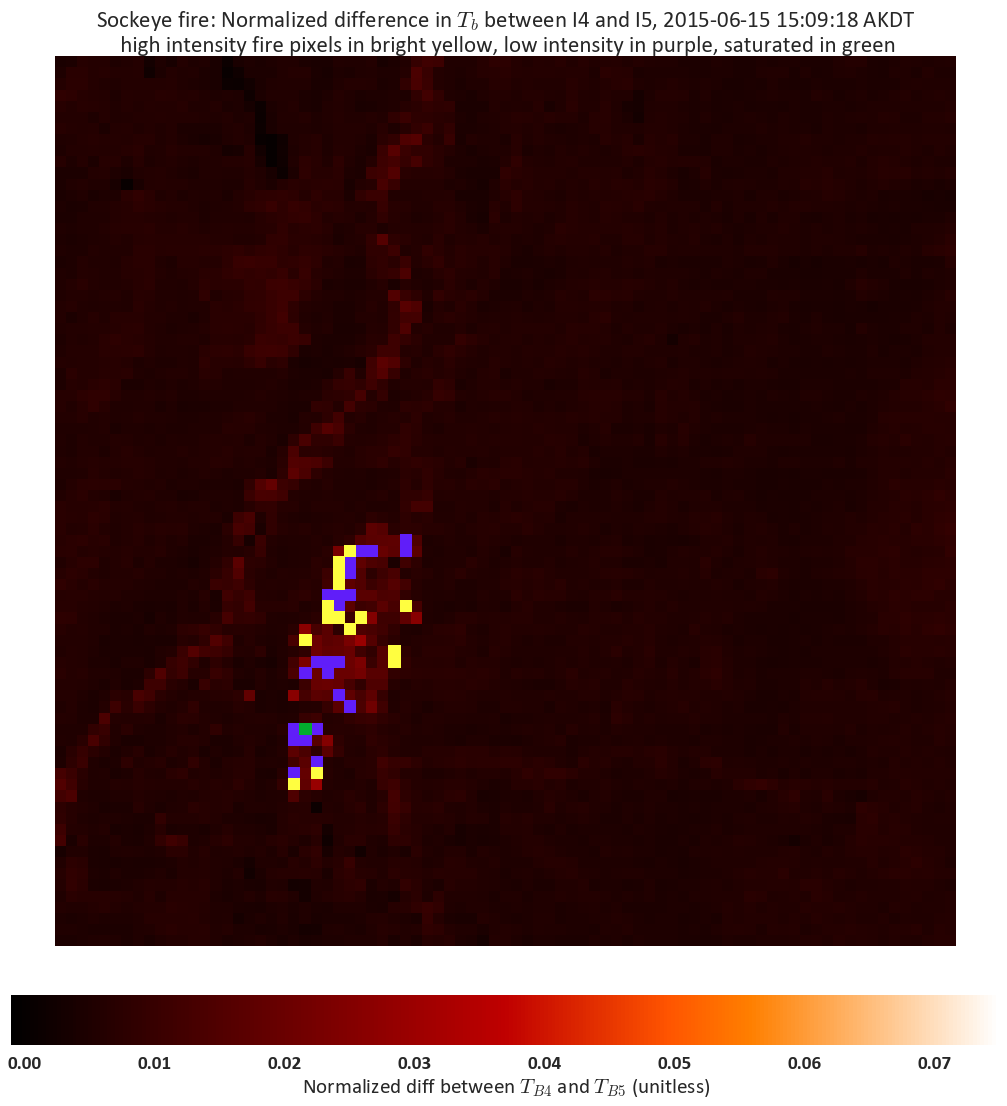

In [55]:
# sith plot: masked over normalized difference or TB4
MASK = True
PLOTB4 = False

sns.set_context("poster", font_scale=1.2)

plotraster4 = np.delete(rasterlist[0], skiprows, 0)
plotraster5 = np.delete(rasterlist[1], skiprows, 0)
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)
pixq4 = np.delete(pixelq4, skiprows, 0)
pixq5 = np.delete(pixelq5, skiprows, 0)


scene = raster.VIIRSHDF5(testpath01)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster1 = testdat*mult + add
plotraster1 = np.delete(plotraster1, skiprows, 0)

scene = raster.VIIRSHDF5(testpath02)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster2 = testdat*mult + add
plotraster2 = np.delete(plotraster2, skiprows, 0)


cmap4 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'turquoise']))

if PLOTB4:
    titlestr1 = "Sockeye fire: $T_b$ from band I4"
else:
    titlestr1 = "Sockeye fire: Normalized difference in $T_b$ between I4 and I5"

if MASK:
#    duplicatecondition = (skips == 1.)

    if nightscene:
        print("It's night")
        anomalouscondition = np.logical_or(
            np.logical_and(pixq4 == 193, plotraster4 < 360),
            np.logical_and(pixq5 == 0, plotraster4 == 367.))
        plotraster45_anomalousmasked = np.ma.masked_where(
            ~anomalouscondition, np.ones(plotraster45.shape))
        cloudcondition = (plotraster5 < 265.)
        hotcondition = (plotraster45 >= 0.05)
        hotcondition = np.logical_and(~cloudcondition, hotcondition)
        warmcondition = np.logical_and(~hotcondition, plotraster45 >= 0.015)
        warmcondition = np.logical_and(plotraster4 > 290, warmcondition)
        warmcondition = np.logical_and(~cloudcondition, warmcondition)
        cloudcondition = np.logical_and(
            plotraster4 < 295, plotraster5 < 265
        )

    else:
        print("It's day")
        anomalouscondition = np.logical_or(
            np.logical_and(pixq4 == 193, plotraster4 < 360),
            np.logical_and(pixq5 == 0, plotraster4 == 367.))
#        anomalouscondition = np.logical_and(
#            ~duplicatecondition, anomalouscondition)
        
        hotcondition = (plotraster45 >= 0.05)
        hotcondition = np.logical_and(
            np.logical_and(hotcondition, plotraster4 > 320), plotraster5 > 290)
        hotcondition = np.logical_and(
            hotcondition, ~anomalouscondition)
#        hotcondition = np.logical_and(
#            ~duplicatecondition, hotcondition)
        

        warmcondition = np.logical_or(
            plotraster45 >= 0.02, np.logical_and(
                plotraster45 >= 0.015, plotraster5 >= 312))
        warmcondition = np.logical_and(
            warmcondition, plotraster4 > 320)
        warmcondition = np.logical_and(
            warmcondition, ~anomalouscondition)
        warmcondition = np.logical_and(
            warmcondition, ~hotcondition)
#        warmcondition = np.logical_and(
#            ~duplicatecondition, warmcondition)

        cloudcondition = np.logical_or(
            plotraster5 < 265, 
            np.logical_and(plotraster1 + plotraster2 > 0.9, plotraster5 < 295))
        cloudcondition = np.logical_or(
            cloudcondition,
            np.logical_and(plotraster1 + plotraster2 > 0.7, plotraster5 < 285),)
    cloudmask = np.ma.masked_where(
        ~cloudcondition, np.ones(plotraster5.shape))
    plotraster45_masked = np.ma.masked_where(
        ~hotcondition, np.ones(plotraster45.shape))
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    plotraster45_anomalousmasked = np.ma.masked_where(
        ~anomalouscondition, np.ones(plotraster45.shape))

    cmap1 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
    cmap2 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
    cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'kelly green']))
    
    plottitle = '{}, {}\n high intensity fire pixels in bright yellow, low intensity in purple, saturated in green'.format(
        titlestr1, datestamp)
else:
    plottitle = '{}, {}'.format(titlestr1, datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

if PLOTB4:
    dataplot = ax1.pcolormesh(np.fliplr(plotraster4), vmin=280, vmax=370) 
    cbarlabel = "$T_B$ in $K$"
else:
    dataplot = ax1.pcolormesh(np.fliplr(plotraster45), vmin=-.001, vmax=0.075)   
    cbarlabel = "Normalized diff between $T_{B4}$ and $T_{B5}$ (unitless)"


if MASK:
    dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
    dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
    dataplot4 = ax1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)
    cloudplot = ax1.pcolormesh(np.fliplr(cloudmask), cmap=cmap4, alpha=0.5, vmin=0, vmax=1)

ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(20, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()

cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label(cbarlabel)

plt.show()

In [38]:
anomalouscondition.sum() + hotcondition.sum() + warmcondition.sum()

39

In [39]:
for ii, jj in np.argwhere(warmcondition):
    print(plotraster4[ii, jj], plotraster5[ii, jj], plotraster45[ii, jj])

320.601 301.071 0.0314157
321.154 300.449 0.0333087
326.252 302.805 0.0372742
323.525 301.702 0.0349032
324.913 302.597 0.0355616
323.204 300.123 0.0370296
321.309 303.005 0.0293198
325.17 310.751 0.0226738
323.864 310.165 0.021607
323.928 303.71 0.032212
320.45 306.778 0.0217984
322.554 309.172 0.021184
320.776 308.084 0.0201826
327.528 301.808 0.0408697
321.632 309.003 0.0200257
344.752 314.647 0.0456542
325.531 302.415 0.0368129
320.499 306.318 0.0226237
344.375 313.552 0.0468492
334.558 307.747 0.0417425
323.28 310.295 0.0204946
333.26 305.016 0.0442504
324.326 305.072 0.0305904


In [40]:
plotraster4[44, 52]

306.18753

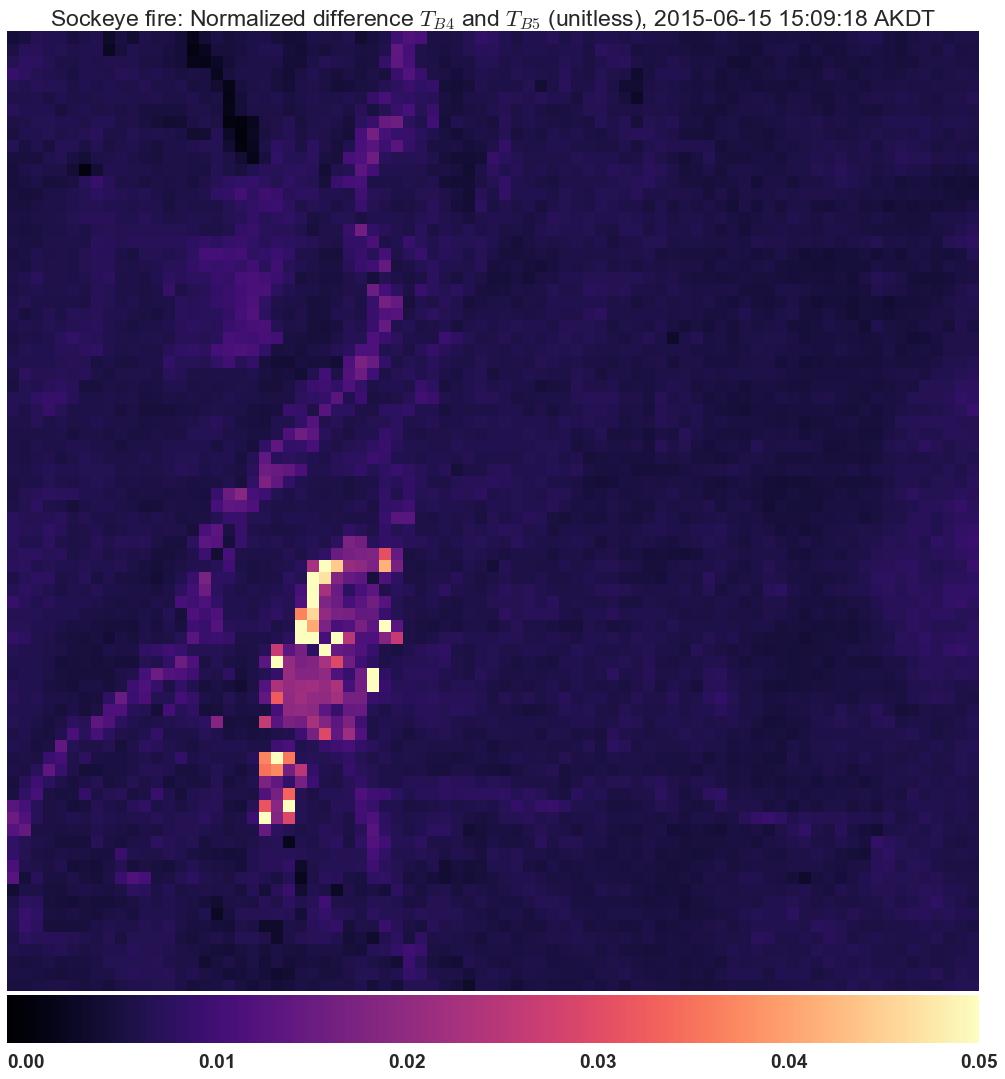

In [96]:
# sith plot: masked over normalized difference or TB4
MASK = False
PLOTB4 = False

sns.set(rc={'image.cmap': 'magma'})
sns.set_context("poster", font_scale=1.2)

plotraster4 = np.delete(rasterlist[0], skiprows, 0)
plotraster5 = np.delete(rasterlist[1], skiprows, 0)
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)
pixq4 = np.delete(pixelq4, skiprows, 0)
pixq5 = np.delete(pixelq5, skiprows, 0)


scene = raster.VIIRSHDF5(testpath01)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster1 = testdat*mult + add
plotraster1 = np.delete(plotraster1, skiprows, 0)

scene = raster.VIIRSHDF5(testpath02)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster2 = testdat*mult + add
plotraster2 = np.delete(plotraster2, skiprows, 0)


cmap4 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'turquoise']))

if PLOTB4:
    titlestr1 = "Sockeye fire: $T_b$ from band I4"
else:
    titlestr1 = "Sockeye fire: Normalized difference $T_{B4}$ and $T_{B5}$ (unitless)"

if MASK:

    if nightscene:
        print("It's night")

        anomalouscondition, hotcondition, warmcondition = vif.getfireconditions_fromrasters(
            plotraster4, plotraster5, pixq4, pixq5, daytime=False)
        cloudcondition = np.logical_and(
            plotraster4 < 295, plotraster5 < 265
        )

    else:
        print("It's day")
        anomalouscondition, hotcondition, warmcondition = vif.getfireconditions_fromrasters(
            plotraster4, plotraster5, pixq4, pixq5, daytime=True)

        cloudcondition = np.logical_or(
            plotraster5 < 265, 
            np.logical_and(plotraster1 + plotraster2 > 0.9, plotraster5 < 295))
        cloudcondition = np.logical_or(
            cloudcondition,
            np.logical_and(plotraster1 + plotraster2 > 0.7, plotraster5 < 285),)
    cloudmask = np.ma.masked_where(
        ~cloudcondition, np.ones(plotraster5.shape))
    plotraster45_masked = np.ma.masked_where(
        ~hotcondition, np.ones(plotraster45.shape))
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    plotraster45_anomalousmasked = np.ma.masked_where(
        ~anomalouscondition, np.ones(plotraster45.shape))

    cmap1 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
    cmap2 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
    cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'kelly green']))
    
    plottitle = '{}, {}\n high intensity fire pixels in bright yellow, low intensity in purple, saturated in green'.format(
        titlestr1, datestamp)
else:
    plottitle = '{}, {}'.format(titlestr1, datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

if PLOTB4:
    dataplot = ax1.pcolormesh(np.fliplr(plotraster4), vmin=280, vmax=370) 
    cbarlabel = "$T_B$ in $K$"
else:
    dataplot = ax1.pcolormesh(np.fliplr(plotraster45), vmin=-0.001, vmax=0.05)   
    cbarlabel = "Normalized diff between $T_{B4}$ and $T_{B5}$ (unitless)"


if MASK:
    dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
    dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
    dataplot4 = ax1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)
    cloudplot = ax1.pcolormesh(np.fliplr(cloudmask), cmap=cmap4, alpha=0.5, vmin=0, vmax=1)

ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(20, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.05)


cbar = fig1.colorbar(dataplot, orientation='horizontal', 
                     cax=cax,
           # pad=cbarpad, fraction=0.04,
            ticks=np.arange(0, 0.1, 0.01))
#cbar.set_label(cbarlabel)

plt.show()

In [83]:
np.arange(0, 0.6, 0.05)

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55])

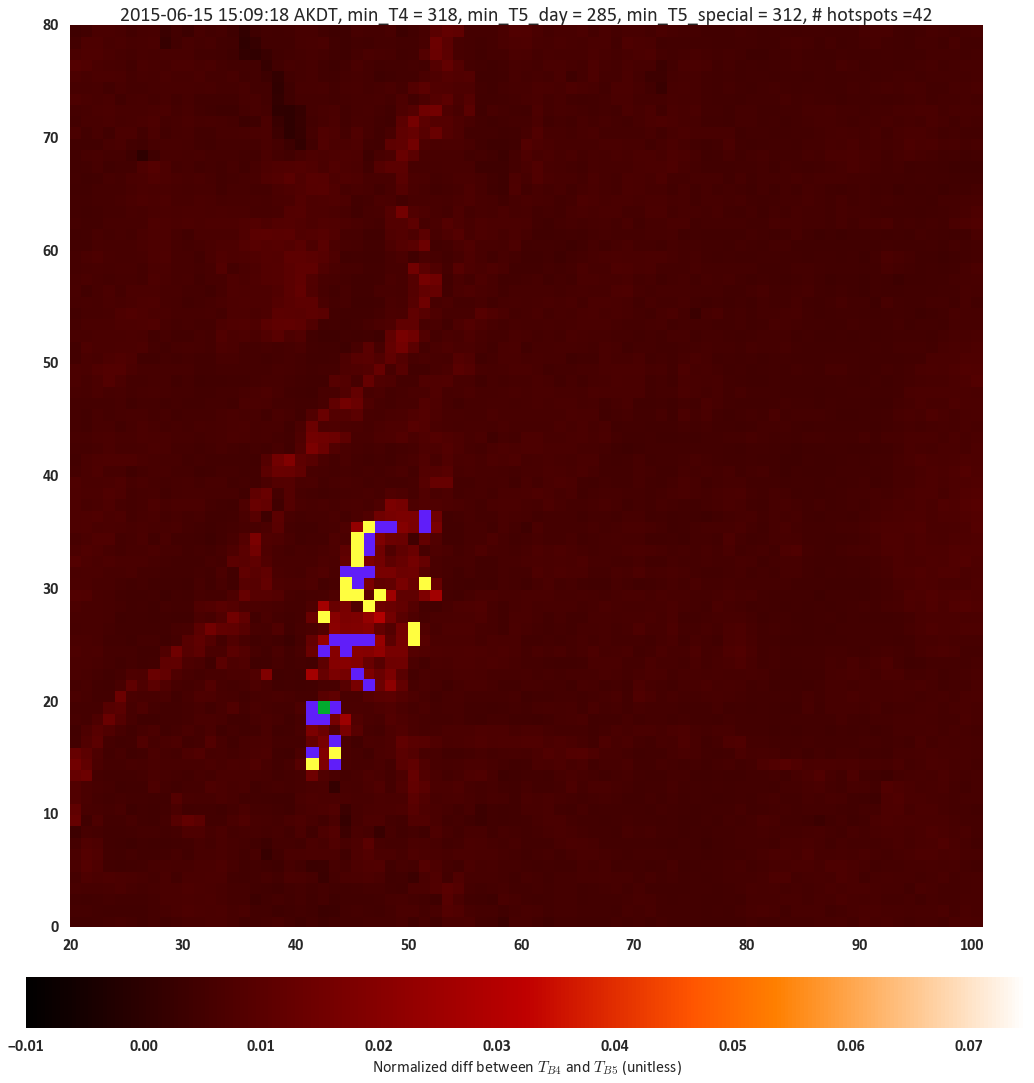

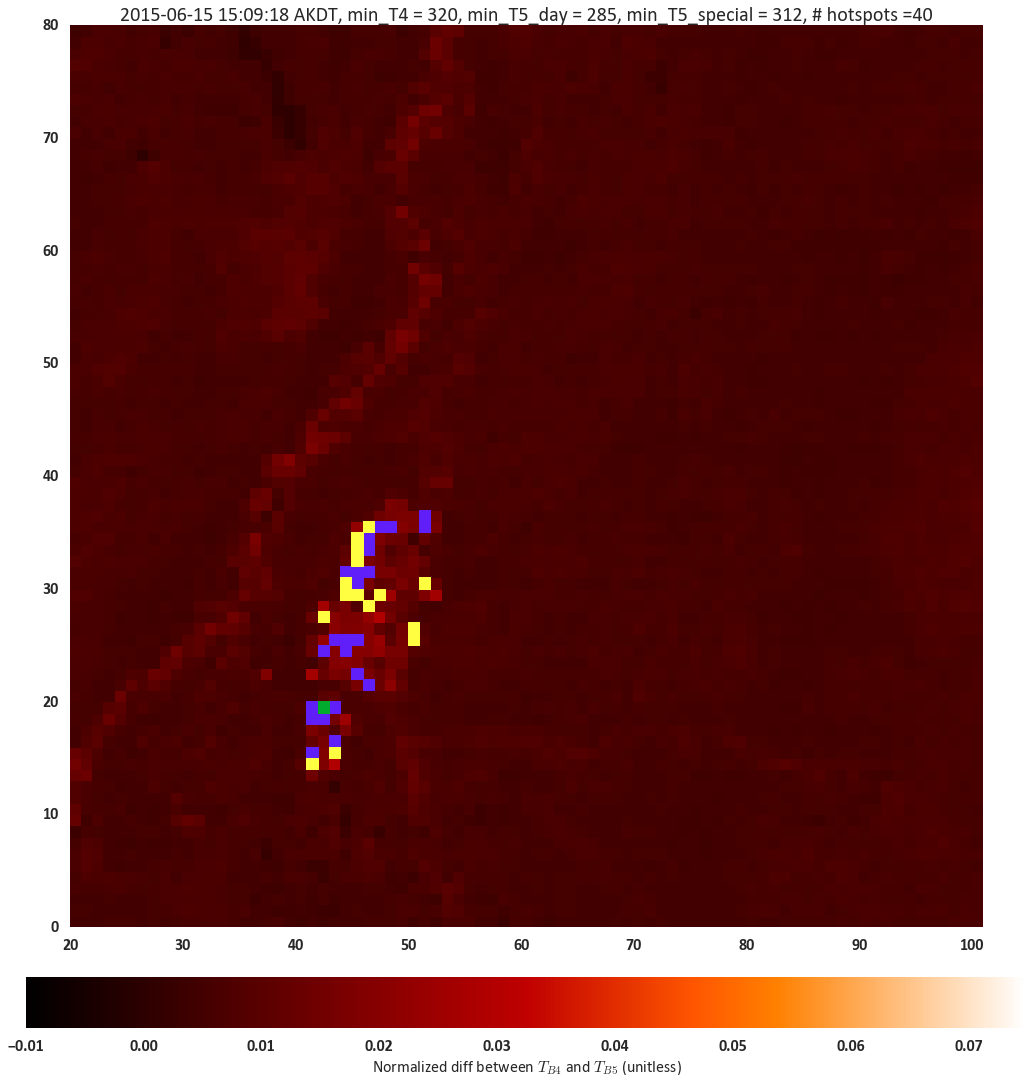

In [43]:
# sith plot: masked over normalized difference or TB4

plotraster4 = np.delete(rasterlist[0], skiprows, 0)
plotraster5 = np.delete(rasterlist[1], skiprows, 0)
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)
pixq4 = np.delete(pixelq4, skiprows, 0)
pixq5 = np.delete(pixelq5, skiprows, 0)

scene = raster.VIIRSHDF5(testpath01)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster1 = testdat*mult + add
plotraster1 = np.delete(plotraster1, skiprows, 0)

scene = raster.VIIRSHDF5(testpath02)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster2 = testdat*mult + add
plotraster2 = np.delete(plotraster2, skiprows, 0)

cmap1 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
cmap2 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'kelly green']))
cmap4 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'turquoise']))

#titlestr1 = "Sockeye fire: Normalized difference in $T_b$ between I4 and I5"

for mint4 in range(318, 321, 2):
    mint5_special=312
    mint5_day=285
    anomalouscondition, hotcondition, warmcondition = vif.getfireconditions_fromrasters(
            plotraster4, plotraster5, pixq4, pixq5, 
            mint4=mint4, mint5_special=mint5_special, mint5_day=mint5_day)

    plotraster45_masked = np.ma.masked_where(
        ~hotcondition, np.ones(plotraster45.shape))
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    plotraster45_anomalousmasked = np.ma.masked_where(
        ~anomalouscondition, np.ones(plotraster45.shape))

    numdetections = anomalouscondition.sum() + hotcondition.sum() + warmcondition.sum()
    #plottitle = '{}, {}\n high intensity fire pixels in bright yellow, low intensity in purple, saturated in green'.format(
    #    titlestr1, datestamp)
    plottitle = '{}, min_T4 = {}, min_T5_day = {}, min_T5_special = {}, # hotspots ={}'.format(
        datestamp, mint4, mint5_day, mint5_special, numdetections)

    fig1 = plt.figure(1, figsize=(15, 15))
    ax1 = fig1.add_subplot(111)
    #ax1.set_xticklabels([])
    #ax1.set_yticklabels([])
    ax1.grid(False)

    dataplot = ax1.pcolormesh(np.fliplr(plotraster45), vmin=-.01, vmax=0.075)   
    dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
    dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
    dataplot4 = ax1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)

    ax1.set_title(plottitle)
    ax1.set_aspect('equal')
    ax1.set_xlim(20, plotraster.shape[1])
    ax1.set_ylim(0, plotraster.shape[0])
    plt.tight_layout()

    cbarlabel = "Normalized diff between $T_{B4}$ and $T_{B5}$ (unitless)"
    cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
    cbar.set_label(cbarlabel)

    plt.show()



In [56]:
fig1.savefig("/Users/cwaigl/Desktop/testfires_after.png", dpi=300)


In [55]:
anomalouscondition.sum() + hotcondition.sum() + warmcondition.sum()

116

In [111]:
skiprows

array([ 4,  5,  6,  7,  8,  9, 10, 36, 37, 38, 39, 40, 41, 42, 68, 69, 70,
       71, 72, 73, 74])

In [53]:
# sith plot: masked over normalized difference or TB4
MASK = True
PLOTB4 = False

plotraster4 = rasterlist[0]
plotraster5 = rasterlist[1]
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)

scene = raster.VIIRSHDF5(testpath01)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster1 = testdat*mult + add
plotraster1 = np.delete(plotraster1, excluderows, 0)

scene = raster.VIIRSHDF5(testpath02)
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['Reflectance'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['ReflectanceFactors'][:]
plotraster2 = testdat*mult + add
plotraster2 = np.delete(plotraster2, excluderows, 0)


cmap4 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'turquoise']))

if PLOTB4:
    titlestr1 = "Sockeye fire: $T_b$ from band I4"
else:
    titlestr1 = "Sockeye fire: Normalized difference in $T_b$ between I4 and I5"

if MASK:
    duplicatecondition = (np.delete(skips, excluderows, 0) == 1.)

    if nightscene:
        anomalouscondition = np.logical_or(
            np.logical_and(pixq4 == 193, plotraster4 < 360),
            np.logical_and(pixq5 == 0, plotraster4 == 367.))
        plotraster45_anomalousmasked = np.ma.masked_where(
            ~anomalouscondition, np.ones(plotraster45.shape))
        cloudcondition = (plotraster5 < 265.)
        hotcondition = (plotraster45 >= 0.05)
        hotcondition = np.logical_and(~cloudcondition, hotcondition)
        warmcondition = np.logical_and(~hotcondition, plotraster45 >= 0.015)
        warmcondition = np.logical_and(plotraster4 > 290, warmcondition)
        warmcondition = np.logical_and(~cloudcondition, warmcondition)
        cloudcondition = np.logical_and(
            plotraster4 < 295, plotraster5 < 265
        )

    else:
        # it's day 
        anomalouscondition = np.logical_or(
            np.logical_and(pixq4 == 193, plotraster4 < 360),
            np.logical_and(pixq5 == 0, plotraster4 == 367.))
        anomalouscondition = np.logical_and(
            ~duplicatecondition, anomalouscondition)
        
        hotcondition = (plotraster45 >= 0.05)
        hotcondition = np.logical_and(
            np.logical_and(hotcondition, plotraster4 > 320), plotraster5 > 290)
        hotcondition = np.logical_and(
            hotcondition, ~anomalouscondition)
        hotcondition = np.logical_and(
            ~duplicatecondition, hotcondition)
        

        warmcondition = np.logical_or(
            plotraster45 >= 0.02, np.logical_and(
                plotraster45 >= 0.015, plotraster5 >= 312))
        warmcondition = np.logical_and(
            warmcondition, plotraster4 > 320)
        warmcondition = np.logical_and(
            ~duplicatecondition, warmcondition)

        cloudcondition = np.logical_or(
            plotraster5 < 265, 
            np.logical_and(plotraster1 + plotraster2 > 0.9, plotraster5 < 295))
        cloudcondition = np.logical_or(
            cloudcondition,
            np.logical_and(plotraster1 + plotraster2 > 0.7, plotraster5 < 285),)
    cloudmask = np.ma.masked_where(
        ~cloudcondition, np.ones(plotraster5.shape))
    plotraster45_masked = np.ma.masked_where(
        ~hotcondition, np.ones(plotraster45.shape))
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    plotraster45_anomalousmasked = np.ma.masked_where(
        ~anomalouscondition, np.ones(plotraster45.shape))

    cmap1 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
    cmap2 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))
    cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'kelly green']))
    
    plottitle = '{}, {}\n high intensity fire pixels in bright yellow, low intensity in purple, saturated in green'.format(
        titlestr1, datestamp)
else:
    plottitle = '{}, {}'.format(titlestr1, datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

if PLOTB4:
    dataplot = ax1.pcolormesh(np.fliplr(plotraster4), vmin=280, vmax=370) 
    cbarlabel = "$T_B$ in $K$"
else:
    dataplot = ax1.pcolormesh(np.fliplr(plotraster45), vmin=0.0, vmax=0.09)   
    cbarlabel = "Normalized diff between $T_{B4}$ and $T_{B5}$ (unitless)"


if MASK:
    dataplot3 = ax1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
    dataplot2 = ax1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
    dataplot4 = ax1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)
    cloudplot = ax1.pcolormesh(np.fliplr(cloudmask), cmap=cmap4, alpha=0.5, vmin=0, vmax=1)

ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(20, plotraster.shape[1])
ax1.set_ylim(0, plotraster.shape[0])
plt.tight_layout()

cbar = fig1.colorbar(dataplot, orientation='horizontal', pad=cbarpad, fraction=cbarfraction)
cbar.set_label(cbarlabel)

plt.show()



ValueError: operands could not be broadcast together with shapes (575,1701) (1277,1701) 

In [63]:
fn = 'viirscloudmask02NormDiff.png'
fig1.savefig(os.path.join(outdir, fn), bb_inches='tight', dpi=200)

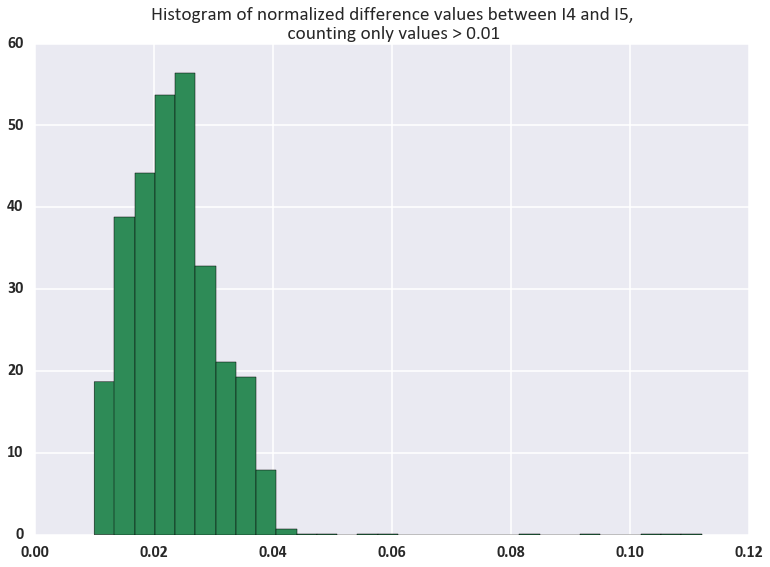

In [106]:
normdiffs = plotraster45.flatten()
values = normdiffs[normdiffs>0.01]
n, bins, patches = plt.hist(values, 30, normed=1, facecolor='seagreen') 
plt.title("Histogram of normalized difference values between I4 and I5,\n counting only values > 0.01")

In [37]:
i4sc = raster.VIIRSHDF5(i04paths[IDX])
i5sc = raster.VIIRSHDF5(i05paths[IDX])
imin, imax, jmin, jmax = i4sc.crop(sample_lat, sample_lon, 125, 125)

ascendingnode = True
middlelatdelta = i4sc.lats[-1, 3200] - i4sc.lats[0, 3200]
if middlelatdelta < 0:
    ascendingnode = False 
i4sc.ascendingnode = ascendingnode
skips = get_skips(i4sc, imin=imin, imax=imax, jmin=jmin, jmax=jmax)

lons = i4sc.lons[imin:imax, jmin:jmax]
lats = i4sc.lats[imin:imax, jmin:jmax]

mult, add = i4sc.I4['BrightnessTemperatureFactors'][:]
i4tb = i4sc.I4['BrightnessTemperature'][imin:imax, jmin:jmax]
i4tb = i4tb * mult + add
mult, add = i5sc.I5['BrightnessTemperatureFactors'][:]
i5tb = i5sc.I5['BrightnessTemperature'][imin:imax, jmin:jmax]
i5tb = i5tb * mult + add
pixq4 = i4sc.pixelquality[imin:imax, jmin:jmax]
pixq5 = i5sc.pixelquality[imin:imax, jmin:jmax]

nightscene = True
zenithangles = i4sc.geodata['SolarZenithAngle'][imin:imax, jmin:jmax]
if np.all(zenithangles <= 90.):
    nightscene = False
elif (np.any(zenithangles > 90.) & np.any(zenithangles <= 90.)):
    print("WARNING: mixed scene with zenith angles above and below 90°.")

i45 =  (i4tb - i5tb) / (i4tb + i5tb)

datestamp = vt.getdatestamp_AKDT(i4sc)

# conditions
duplicatecondition = (skips == 1.)

if nightscene:
    print("Night scene")
    anomalouscondition = np.logical_or(
        np.logical_and(pixq4 == 193, i4tb < 360),
        np.logical_and(pixq5 == 0, i4tb == 367.))
    anomalouscondition = np.logical_and(
        ~duplicatecondition, anomalouscondition)
    cloudcondition = (i5tb < 265.)
    hotcondition = (i45 >= 0.05)
    hotcondition = np.logical_and(~cloudcondition, hotcondition)
    hotcondition = np.logical_and(
        ~duplicatecondition, hotcondition)
    warmcondition = np.logical_and(~hotcondition, i45 >= 0.015)
    warmcondition = np.logical_and(i4tb > 290, warmcondition)
    warmcondition = np.logical_and(~cloudcondition, warmcondition)
    warmcondition = np.logical_and(
        ~duplicatecondition, warmcondition)
else:
# it's day 
    print("Day scene")
    anomalouscondition = np.logical_or(
        np.logical_and(pixq4 == 193, i4tb < 360),
        np.logical_and(pixq5 == 0, i4tb == 367.))
    anomalouscondition = np.logical_and(
        ~duplicatecondition, anomalouscondition)

    hotcondition = (i45 >= 0.05)
    hotcondition = np.logical_and(
        np.logical_and(hotcondition, i4tb > 320), i5tb > 290)
    hotcondition = np.logical_or(
        hotcondition, anomalouscondition)
    hotcondition = np.logical_and(
        ~duplicatecondition, hotcondition)

    warmcondition = np.logical_or(
        i45 >= 0.02, np.logical_and(
            i45 >= 0.015, i5tb >= 308))
    warmcondition = np.logical_and(
        warmcondition, i4tb > 320)
    warmcondition = np.logical_and(
        ~duplicatecondition, warmcondition)

print(np.where(warmcondition))
print(np.where(hotcondition))

Day scene
(array([ 24,  96,  97,  97,  98, 100, 100, 101, 101, 101, 103, 104, 105,
       106, 106, 106, 106, 107, 107, 107, 107, 108, 109, 110, 118, 118,
       118, 119, 119, 119, 120, 120, 120, 121, 122, 122, 123, 123, 124,
       124, 124, 124, 124, 125]), array([ 23, 134, 132, 134, 132, 133, 134, 132, 133, 134, 129, 130, 131,
       130, 131, 132, 133, 125, 130, 131, 132, 125, 133, 129, 128, 130,
       131, 124, 130, 131, 129, 130, 131, 130, 129, 130, 129, 130, 124,
       126, 127, 128, 129, 124]))
(array([ 96,  97, 101, 107, 108, 109, 110, 118, 118, 118, 119, 119, 121,
       122, 123, 124]), array([134, 132, 133, 125, 125, 133, 129, 128, 130, 131, 124, 131, 130,
       130, 130, 129]))


In [38]:
i4sc.meta

{u'Data_Product': {u'AggregateBeginningDate': u'20150615',
  u'AggregateBeginningGranuleID': u'NPP001150817578',
  u'AggregateBeginningOrbitNumber': u'18821',
  u'AggregateBeginningTime': u'230918.352825Z',
  u'AggregateEndingDate': u'20150615',
  u'AggregateEndingGranuleID': u'NPP001150817578',
  u'AggregateEndingOrbitNumber': u'18821',
  u'AggregateEndingTime': u'231042.528429Z',
  u'Instrument_Short_Name': u'VIIRS',
  u'N_Collection_Short_Name': u'VIIRS-I4-SDR',
  u'N_Dataset_Type_Tag': u'SDR',
  u'N_Processing_Domain': u'OPS'},
 u'Distributor': u'cspp',
 u'Mission_Name': u'NPP',
 u'N_Dataset_Source': u'all-',
 u'N_GEO_Ref': u'GITCO_npp_d20150615_t2309183_e2310425_b18821_c20150615233131914882_cspp_dev.h5',
 u'N_HDF_Creation_Date': u'20150615',
 u'N_HDF_Creation_Time': u'233134.583144Z',
 u'Number_of_Data_Products': u'1',
 u'Platform_Short_Name': u'NPP'}

NameError: name 'i04paths' is not defined

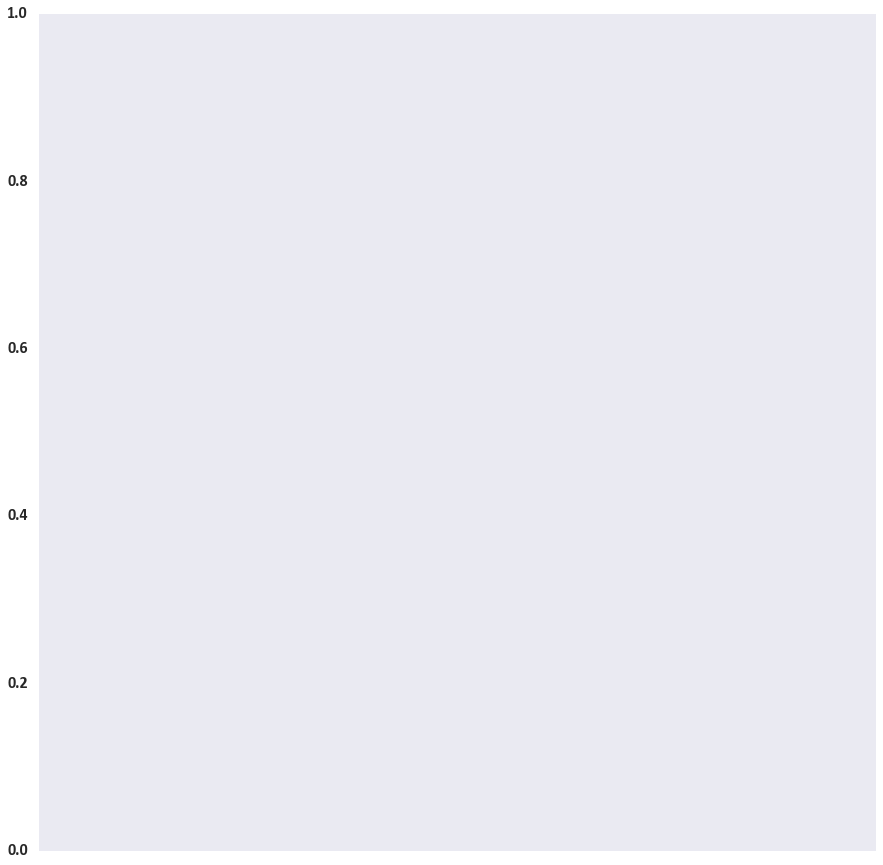

In [105]:
SAVEFIG = False
sns.set_context("poster")

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.grid(False) 

i4sc = raster.VIIRSHDF5(i04paths[IDX])
i5sc = raster.VIIRSHDF5(i05paths[IDX])
imin, imax, jmin, jmax = i4sc.crop(sample_lat, sample_lon, 125, 125)
pixq4 = i4sc.pixelquality[imin:imax, jmin:jmax]
pixq5 = i5sc.pixelquality[imin:imax, jmin:jmax]
# find row indices where no data present
excluderows = np.where((pixq4[:, 0] == 2) | (pixq4[:, -1] == 2) )
pixq4 = np.delete(pixq4, excluderows, 0)
pixq5 = np.delete(pixq5, excluderows, 0)
mult, add = i4sc.I4['BrightnessTemperatureFactors'][:]
i4tb = i4sc.I4['BrightnessTemperature'][imin:imax, jmin:jmax]
i4tb_scaled = i4tb * mult + add
plotraster4 = np.delete(i4tb_scaled, excluderows, 0)
mult, add = i5sc.I5['BrightnessTemperatureFactors'][:]
i5tb = i5sc.I5['BrightnessTemperature'][imin:imax, jmin:jmax]
i5tb_scaled = i5tb * mult + add
plotraster5 = np.delete(i5tb_scaled, excluderows, 0)

ascendingnode = True
middlelatdelta = i4sc.lats[-1, 3200] - i4sc.lats[0, 3200]
if middlelatdelta < 0:
    ascendingnode = False 
i4sc.ascendingnode = ascendingnode
skips = get_skips(i4sc, imin=imin, imax=imax, jmin=jmin, jmax=jmax)
skips = np.delete(skips, excluderows, 0)

nightscene = True
zenithangles = i4sc.geodata['SolarZenithAngle'][imin:imax, jmin:jmax]
if np.all(zenithangles <= 90.):
    nightscene = False
elif (np.any(zenithangles > 90.) & np.any(zenithangles <= 90.)):
    print("WARNING: mixed scene with zenith angles above and below 90°.")

plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)
cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['canary yellow']))
cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['purplish blue']))
cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['kelly green']))

lons = i4sc.lons[imin:imax, jmin:jmax]
lats = i4sc.lats[imin:imax, jmin:jmax]
datestamp = vt.getdatestamp_AKDT(i4sc)

if MASK:

    duplicatecondition = (skips == 1.)
    if nightscene:
        anomalouscondition = np.logical_or(
            np.logical_and(pixq4 == 193, plotraster4 < 360),
            np.logical_and(pixq5 == 0, plotraster4 == 367.))
        anomalouscondition = np.logical_and(
            ~duplicatecondition, anomalouscondition)
        plotraster45_anomalousmasked = np.ma.masked_where(
            ~anomalouscondition, np.ones(plotraster45.shape))
        cloudcondition = (plotraster5 < 265.)
        hotcondition = (plotraster45 >= 0.05)
        hotcondition = np.logical_and(~cloudcondition, hotcondition)
        hotcondition = np.logical_and(
            ~duplicatecondition, hotcondition)
        warmcondition = np.logical_and(~hotcondition, plotraster45 >= 0.015)
        warmcondition = np.logical_and(plotraster4 > 290, warmcondition)
        warmcondition = np.logical_and(~cloudcondition, warmcondition)
        warmcondition = np.logical_and(
            ~duplicatecondition, warmcondition)

    else:
        # it's day 
        anomalouscondition = np.logical_or(
            np.logical_and(pixq4 == 193, plotraster4 < 360),
            np.logical_and(pixq5 == 0, plotraster4 == 367.))
        anomalouscondition = np.logical_and(
            ~duplicatecondition, anomalouscondition)
        
        hotcondition = (plotraster45 >= 0.05)
        hotcondition = np.logical_and(
            np.logical_and(hotcondition, plotraster4 > 320), plotraster5 > 290)
        hotcondition = np.logical_or(
            hotcondition, anomalouscondition)
        hotcondition = np.logical_and(
            ~duplicatecondition, hotcondition)

        warmcondition = np.logical_or(
            plotraster45 >= 0.02, np.logical_and(
                plotraster45 >= 0.015, plotraster5>=312))
        warmcondition = np.logical_and(
            warmcondition, plotraster4 > 320)
        warmcondition = np.logical_and(
            ~duplicatecondition, warmcondition)

    plotraster45_masked = np.ma.masked_where(
        ~hotcondition, np.ones(plotraster45.shape))
    plotraster_cool = np.ma.masked_where(
        ~warmcondition, np.ones(plotraster45.shape))
    plotraster45_anomalousmasked = np.ma.masked_where(
        ~anomalouscondition, np.ones(plotraster45.shape))


# map plot
fig1 = plt.figure(1, figsize=(20, 15))
ax1 = fig1.add_subplot(111)
# mapbase
mm = vt.generate_willowbase(zoom_in=True, resolution='i')
xx, yy = mm(np.delete(lons, excluderows, 0), np.delete(lats, excluderows, 0))
# data 
#dataplt = mm.pcolormesh(xx, yy, plotraster4, edgecolors='None',vmin=280, vmax=370, zorder=2)
dataplot3 = mm.pcolormesh(xx, yy, plotraster_cool, edgecolors='None', cmap=cmap2, vmin=0, vmax=1, zorder=3)
dataplot2 = mm.pcolormesh(xx, yy, plotraster45_masked, edgecolors='None', cmap=cmap1, vmin=0, vmax=1, zorder=3)
dataplot4 = ax1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)
# scale 
mm.drawmapscale(-150.37, 61.95, -150.1, 61.85, 10, barstyle="fancy", fontsize=22, zorder=5)

#cbar = mm.colorbar(dataplt, location='bottom', pad="5%")
mm.readshapefile(
    sideroads, 
    'sideroads', 
    color="grey", linewidth=2, zorder=5)

ax1.set_title(
    'Sockeye fire: High- and low-intensity (bright yellow and purple, respectively) \n burning areas from VIIRS I-band data, {}'.format(datestamp))
if SAVEFIG:
    datestamp = vt.getdatestamp_AKDT(i4sc, spaces=False)
    filename = 'Sockeye_hotspot_map_{}.png'.format(datestamp)
    outpath = os.path.join(productdir, filename)
    fig1.savefig(outpath, dpi=200, bbox_inches='tight')
plt.show()



In [149]:
print(sum(sum(hotcondition)), sum(sum(warmcondition)))
print(np.where(warmcondition))
print(np.where(hotcondition))

1 5
(array([145, 145, 145, 146, 146]), array([121, 122, 123, 121, 123]))
(array([146]), array([122]))


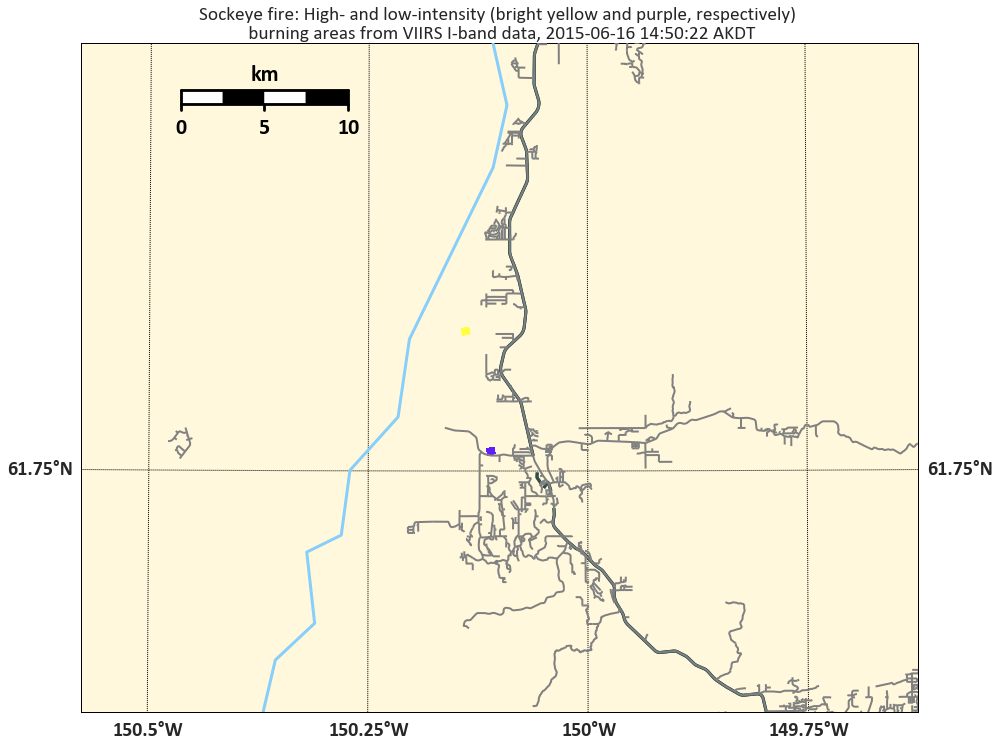

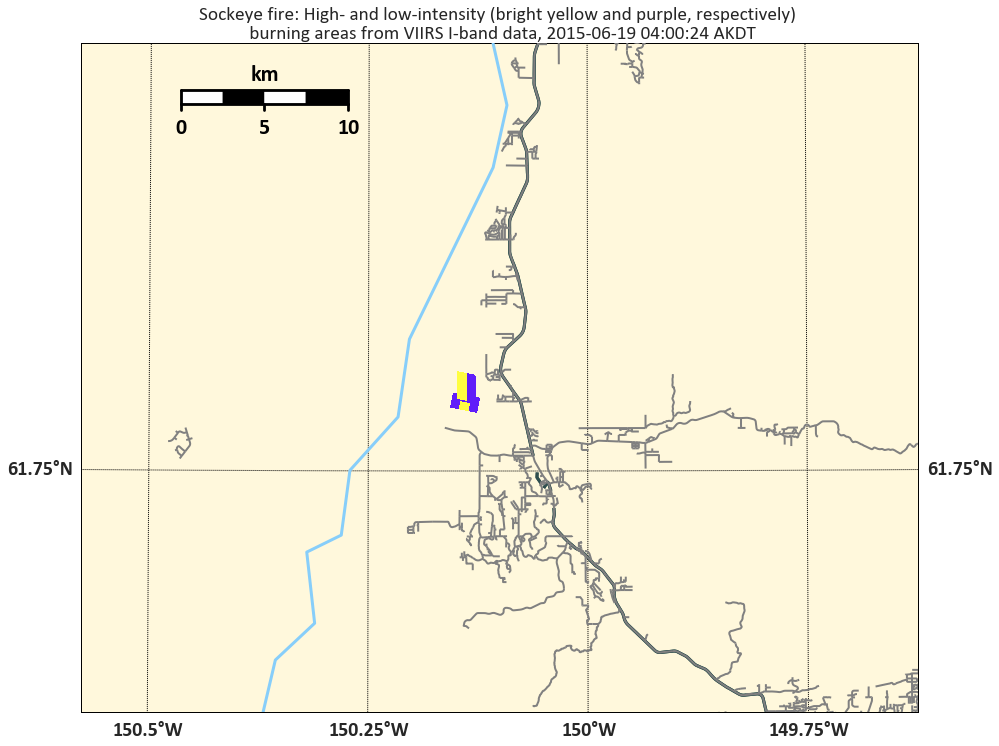

In [131]:
SAVEFIG = True
sns.set_context("poster")

for scindex in range(9, 11):

    fig1 = plt.figure(1, figsize=(15, 15))
    ax1 = fig1.add_subplot(111)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.grid(False) 

    i4sc = raster.VIIRSHDF5(i04paths[scindex])
    i5sc = raster.VIIRSHDF5(i05paths[scindex])
    imin, imax, jmin, jmax = i4sc.crop(sample_lat, sample_lon, 125, 125)
    pixq4 = i4sc.pixelquality[imin:imax, jmin:jmax]
    pixq5 = i5sc.pixelquality[imin:imax, jmin:jmax]
    # find row indices where no data present
    excluderows = np.where((pixq4[:, 0] == 2) | (pixq4[:, -1] == 2) )
    pixq4 = np.delete(pixq4, excluderows, 0)
    pixq5 = np.delete(pixq5, excluderows, 0)
    mult, add = i4sc.I4['BrightnessTemperatureFactors'][:]
    i4tb = i4sc.I4['BrightnessTemperature'][imin:imax, jmin:jmax]
    i4tb_scaled = i4tb * mult + add
    plotraster4 = np.delete(i4tb_scaled, excluderows, 0)
    mult, add = i5sc.I5['BrightnessTemperatureFactors'][:]
    i5tb = i5sc.I5['BrightnessTemperature'][imin:imax, jmin:jmax]
    i5tb_scaled = i5tb * mult + add
    plotraster5 = np.delete(i5tb_scaled, excluderows, 0)

    nightscene = True
    zenithangles = i4sc.geodata['SolarZenithAngle'][imin:imax, jmin:jmax]
    if np.all(zenithangles <= 90.):
        nightscene = False
    elif (np.any(zenithangles > 90.) & np.any(zenithangles <= 90.)):
        print("WARNING: mixed scene with zenith angles above and below 90°.")

    plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)
    cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['canary yellow']))
    cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['purplish blue']))
    cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'kelly green']))

    lons = i4sc.lons[imin:imax, jmin:jmax]
    lats = i4sc.lats[imin:imax, jmin:jmax]
    datestamp = vt.getdatestamp_AKDT(i4sc)

    if MASK:

        if nightscene:
            anomalouscondition = np.logical_or(
                np.logical_and(pixq4 == 193, plotraster4 < 360),
                np.logical_and(pixq5 == 0, plotraster4 == 367.))
            plotraster45_anomalousmasked = np.ma.masked_where(
                ~anomalouscondition, np.ones(plotraster45.shape))
            cloudcondition = (plotraster5 < 265.)
            hotcondition = (plotraster45 >= 0.05)
            hotcondition = np.logical_and(~cloudcondition, hotcondition)
            warmcondition = np.logical_and(~hotcondition, plotraster45 >= 0.015)
            warmcondition = np.logical_and(plotraster4 > 290, warmcondition)
            warmcondition = np.logical_and(~cloudcondition, warmcondition)

        else:
            # it's day 
            anomalouscondition = np.logical_or(
                np.logical_and(pixq4 == 193, plotraster4 < 360),
                np.logical_and(pixq5 == 0, plotraster4 == 367.))

            hotcondition = (plotraster45 >= 0.05)
            hotcondition = np.logical_and(
                np.logical_and(hotcondition, plotraster4 > 320), plotraster5 > 290)
            hotcondition = np.logical_or(
                hotcondition, anomalouscondition)

            warmcondition = np.logical_or(
                plotraster45 >= 0.02, np.logical_and(
                    plotraster45 >= 0.015, plotraster5>=308))
            warmcondition = np.logical_and(
                warmcondition, plotraster4 > 320)

        plotraster45_masked = np.ma.masked_where(
            ~hotcondition, np.ones(plotraster45.shape))
        plotraster_cool = np.ma.masked_where(
            ~warmcondition, np.ones(plotraster45.shape))
        plotraster45_anomalousmasked = np.ma.masked_where(
            ~anomalouscondition, np.ones(plotraster45.shape))


    # map plot
    fig1 = plt.figure(1, figsize=(20, 15))
    ax1 = fig1.add_subplot(111)
    # mapbase
    mm = vt.generate_willowbase(zoom_in=True, resolution='i')
    xx, yy = mm(np.delete(lons, excluderows, 0), np.delete(lats, excluderows, 0))
    # data 
    #dataplt = mm.pcolormesh(xx, yy, plotraster4, edgecolors='None',vmin=280, vmax=370, zorder=2)
    dataplot3 = mm.pcolormesh(xx, yy, plotraster_cool, edgecolors='None', cmap=cmap2, vmin=0, vmax=1, zorder=3)
    dataplot2 = mm.pcolormesh(xx, yy, plotraster45_masked, edgecolors='None', cmap=cmap1, vmin=0, vmax=1, zorder=3)
    dataplot4 = ax1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)
    # scale 
    mm.drawmapscale(-150.37, 61.95, -150.1, 61.85, 10, barstyle="fancy", fontsize=22, zorder=5)

    #cbar = mm.colorbar(dataplt, location='bottom', pad="5%")
    mm.readshapefile(
        sideroads, 
        'sideroads', 
        color="grey", linewidth=2, zorder=5)

    ax1.set_title(
        'Sockeye fire: High- and low-intensity (bright yellow and purple, respectively) \n burning areas from VIIRS I-band data, {}'.format(datestamp))
    if SAVEFIG:
        datestamp = vt.getdatestamp_AKDT(i4sc, spaces=False)
        filename = 'Sockeye_hotspot_map_{}.png'.format(datestamp)
        outpath = os.path.join(productdir, filename)
        fig1.savefig(outpath, dpi=200, bbox_inches='tight')
    plt.show()

In [98]:
reload(vt)

<module 'viirstools' from 'viirstools.py'>

In [48]:
sns.set_context("poster")

## Investigating duplicate data and raster properties

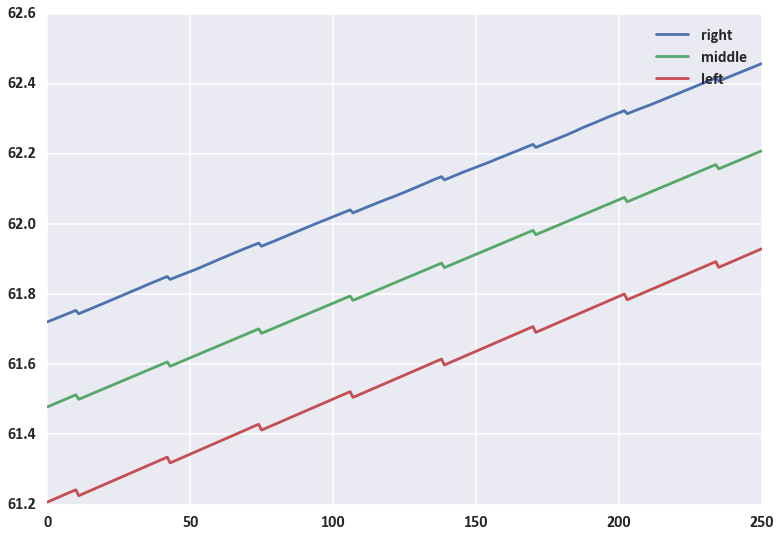

In [54]:
plt.plot(range(imax-imin), testscene04.lats[imin:imax, jmin], label='right')
plt.plot(range(imax-imin), testscene04.lats[imin:imax, (jmax+jmin)//2], label='middle')
plt.plot(range(imax-imin), testscene04.lats[imin:imax, jmax], label='left')
plt.legend()

In [55]:
scene = testscene04
bandname = scene.bandname
testdat4 = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]

#plotraster4 = np.delete(testdat4, excluderows, 0)
testdat4 = testdat4*mult + add
lons = testscene04.lons[imin:imax, jmin:jmax]
lats = testscene04.lats[imin:imax, jmin:jmax]
lons.shape, lats.shape, testdat4.shape

((251, 251), (251, 251), (251, 251))

In [56]:
ascendingnode

True

In [58]:
deltas = lats[:-1, :] - lats[1:, :]
if ascendingnode:
    deltas[deltas > 0] = 0
else:
    deltas[deltas < 0] = 0

right = np.where(deltas[:, 0] == 0)[0]
left = np.where(deltas[:, -1] == 0)[0]
middle = np.where(deltas[:, deltas.shape[1]//2] == 0)[0]

In [66]:
from functools import reduce, partial
zeros = reduce(np.union1d, (right, left, middle))
print(zeros)

[ 10  42  74 106 138 170 202 234]


In [67]:
print(len(lats[:-1, :]))
print(np.max(zeros, axis=0))
print(testscene04.ascendingnode)

250
234
True


In [71]:
def get_skips_by_col(col, zeros=[], length=None, ascending=True):
    if not length:
        length = col.shape[0]
    if len(zeros) == 0:
        return []
    skipindices = []
    outcol = np.zeros(length)
    if length < np.max(np.max(zeros)):
        print("*** ERROR in function get_skips_by_col: index out of range")
        return
    fac = 1.
    if not ascending:
        fac = -1.
    for idx in zeros:
        step = np.argmax(fac*col[idx:] > fac*col[idx])
        if step == 0:
            skipindices.extend(range(idx+1, length))
        else:
            halfstepL = step//2
            if halfstepL > idx:
                halfstepL == idx
            halfstepR = step - halfstepL
            skipindices.extend(range(idx-halfstepL+1, idx+halfstepR))
    outcol[skipindices] = 1.
    return outcol

get_skips_for_lats = partial(get_skips_by_col, zeros=zeros, length=imax-imin)

skips = np.apply_along_axis(get_skips_for_lats, 0, 
    testscene04.lats[imin:imax, jmin:jmax], 
    ascending=testscene04.ascendingnode)
#get_skips_for_lats(lats[:, 1], zeros=zeros, length=lats.shape[0], ascending=True)

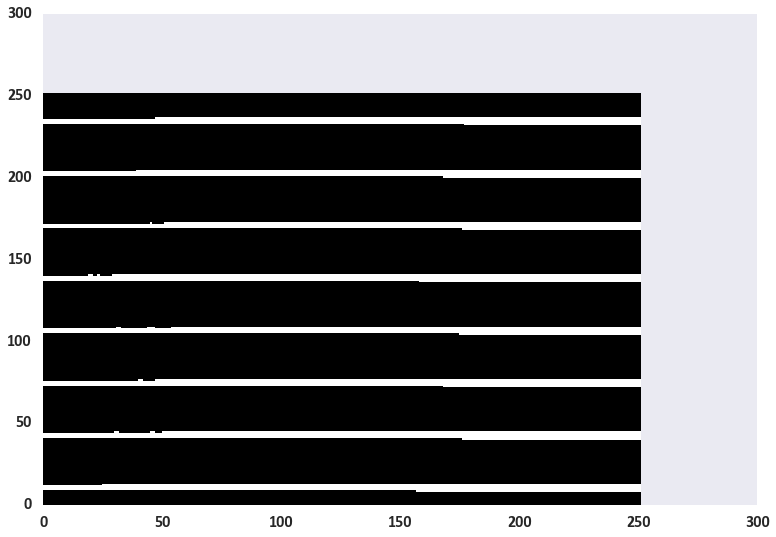

In [72]:
plt.pcolormesh(skips)

<matplotlib.colorbar.Colorbar instance at 0x1214b5cf8>

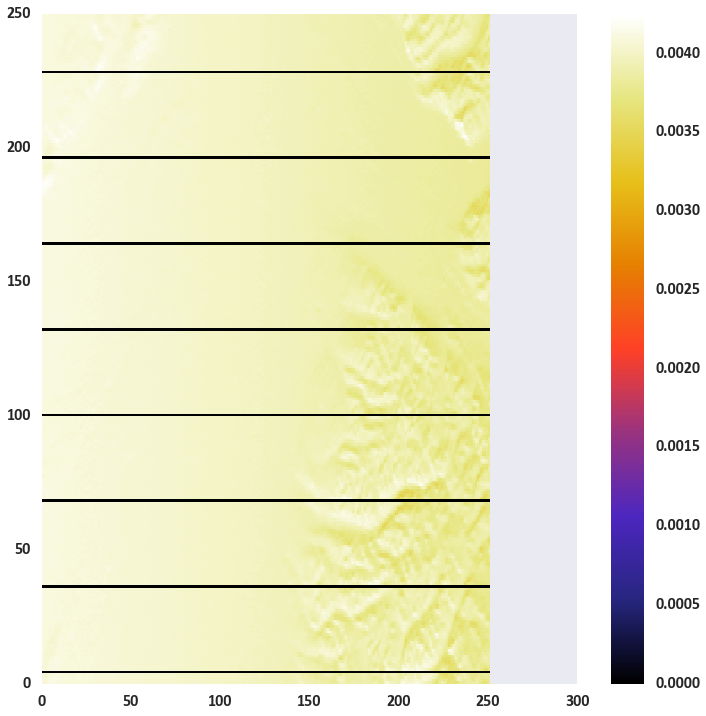

In [26]:
fig1 = plt.figure(1, figsize=(12, 12))
ax1 = fig1.add_subplot(111)
dataplt = plt.pcolormesh(deltas, cmap='CMRmap')
plt.colorbar(dataplt)

<matplotlib.colorbar.Colorbar instance at 0x121428248>

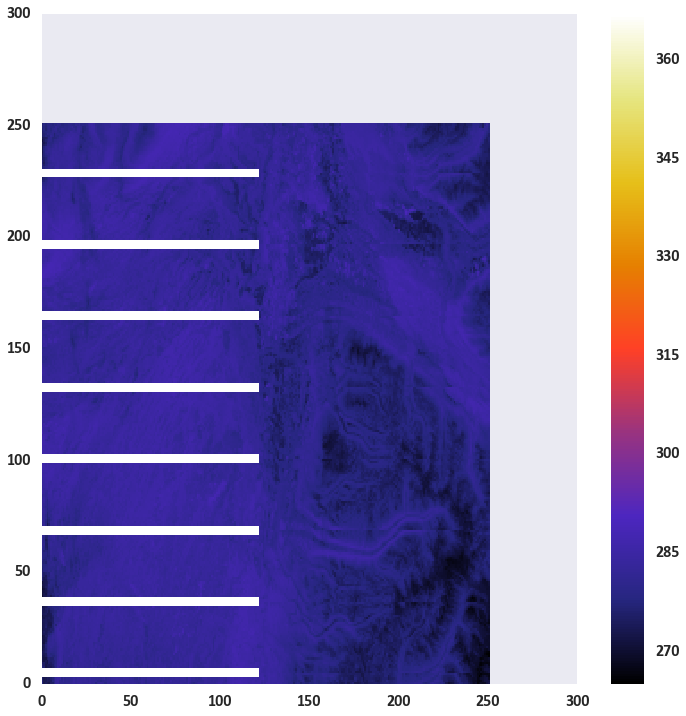

In [27]:
fig1 = plt.figure(1, figsize=(12, 12))
ax1 = fig1.add_subplot(111)
dataplt = plt.pcolormesh(testdat4, cmap='CMRmap')
plt.colorbar(dataplt)

In [28]:
lons_scrub = np.delete(testscene04.lons[imin:imax, jmin:jmax], excluderows, 0)
lats_scrub = np.delete(testscene04.lats[imin:imax, jmin:jmax], excluderows, 0)
testdat4_scrub = np.delete(testdat4, excluderows, 0)

In [29]:
i,j = np.unravel_index(testdat4_scrub.argmax(), testdat4_scrub.shape)
i, j

(183, 204)

In [30]:
testdat4[i, j], lats[i, j], lons[i, j]

(285.09656, 61.592575, -149.3299)

In [31]:
%%timeit
def get_corners_simple(i, j, scene):
    corners = []
    for deli in [1, -1]: 
        for delj in [1, -1]:
            newlon = (scene.lons[i+deli, j+delj] + scene.lons[i, j])/2
            newlat = (scene.lats[i+deli, j+delj] + scene.lats[i, j])/2
            corners.append((newlon, newlat))
    return corners

print(get_corners_simple(i, j, testscene04))

[(-166.78416442871094, 63.358558654785156), (-166.79762268066406, 63.357948303222656), (-166.78547668457031, 63.365348815917969), (-166.7989501953125, 63.364738464355469)]
[(-166.78416442871094, 63.358558654785156), (-166.79762268066406, 63.357948303222656), (-166.78547668457031, 63.365348815917969), (-166.7989501953125, 63.364738464355469)]
[(-166.78416442871094, 63.358558654785156), (-166.79762268066406, 63.357948303222656), (-166.78547668457031, 63.365348815917969), (-166.7989501953125, 63.364738464355469)]
[(-166.78416442871094, 63.358558654785156), (-166.79762268066406, 63.357948303222656), (-166.78547668457031, 63.365348815917969), (-166.7989501953125, 63.364738464355469)]
1 loops, best of 3: 4.64 s per loop


In [32]:
%%timeit
def get_corners_wgs(i, j, scene):
    import pyproj
    g = pyproj.Geod(ellps='WGS84')    
    corners = []
    for deli in [1, -1]: 
        for delj in [1, -1]:
            fwd_az, bck_az, dist = g.inv(
                scene.lons[i, j], scene.lats[i, j], 
                scene.lons[i+deli, j+delj], scene.lats[i+deli, j+delj])
            newlon, newlat, bck_az = g.fwd(scene.lons[i, j], scene.lats[i, j] , fwd_az, dist/2.)
            corners.append((newlon, newlat))
    return corners

print(get_corners_wgs(i, j, testscene04))

[(-166.7841636358744, 63.3585588464854), (-166.7976234617886, 63.357946526015894), (-166.78547746514207, 63.36534703868403), (-166.7989417715582, 63.36474056376903)]
[(-166.7841636358744, 63.3585588464854), (-166.7976234617886, 63.357946526015894), (-166.78547746514207, 63.36534703868403), (-166.7989417715582, 63.36474056376903)]
[(-166.7841636358744, 63.3585588464854), (-166.7976234617886, 63.357946526015894), (-166.78547746514207, 63.36534703868403), (-166.7989417715582, 63.36474056376903)]
[(-166.7841636358744, 63.3585588464854), (-166.7976234617886, 63.357946526015894), (-166.78547746514207, 63.36534703868403), (-166.7989417715582, 63.36474056376903)]
1 loops, best of 3: 7.05 s per loop
